In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.stats import poisson, norm
from scipy.spatial import ConvexHull
import fnmatch


import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))
def theta_x(x, y, z):
    return x/z

def theta_y(x, y, z):
    return y/z
def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi
    
def theta_x_y(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    tanx = theta_x(x_vec, y_vec, z_vec)
    tany = theta_y(x_vec, y_vec, z_vec)
    
    return tanx, tany

In [2]:
#output_file = free_file.replace(".root", ".pkl")
path = '/home/jiajun/muography/data/planar/'
files = sorted(os.listdir(path))

In [5]:
with ur.open("/home/jiajun/muography/data/AI/AI_target_2.edm4hep.root:events") as f:
    arrays = f.arrays()

In [4]:
for config in ['free','target']:

    batches = pd.DataFrame()
    output_file = f'{config}_merge.pkl'
    for file in files:
        if 'merge' in file: continue
        if config not in file: continue
    
        with ur.open(path+file+":events") as f:
            arrays = f.arrays(filter_name=["MuographyHits.energy", "MuographyHitsContributions.time", 
                                           "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", 
                                           "MCParticles.PDG", "MCParticles.generatorStatus", 
                                           "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", 
                                           "MCParticles.vertex.x", "MCParticles.vertex.y", "MCParticles.vertex.z", 
                                           "MCParticles.mass"])
            
        y,x=np.histogram(ak.flatten(arrays["MuographyHits.energy"]), bins=100, range=(0, 0.004))
        bc=(x[1:]+x[:-1])/2
        MIP=list(bc[y==max(y[3:])])[0] 
        plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
        plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
        plt.xlabel('Cell Energy (MeV)')
        plt.legend()
        plt.close()
        
        data_energy = arrays[f'MuographyHits.energy']
        
        sigma = 0.56
        
        # flatten to numpy
        flat = ak.to_numpy(data_energy.layout.content)
        noise = np.random.normal(0, sigma, size=len(flat))*MIP
        
        # add noise
        flat_smear = np.clip(flat + noise, a_min=1e-16, a_max=None)
        
        offsets = ak.to_numpy(data_energy.layout.offsets)  # convert Index64 → numpy
        lengths = offsets[1:] - offsets[:-1]
        data_energy_smear = ak.unflatten(flat_smear, lengths)
        
        data_MIP_cut = data_energy_smear > 0.2*MIP
        data_cell_cut = ak.num(arrays[f'MuographyHits.energy'], axis=1) >= 2
        
        data_energy = data_energy[data_cell_cut]
        data_energy_smear = data_energy_smear[data_cell_cut]
        data_x = arrays[f'MuographyHits.position.x'][data_cell_cut]
        data_y = arrays[f'MuographyHits.position.y'][data_cell_cut]
        data_z = arrays[f'MuographyHits.position.z'][data_cell_cut]    
        reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
        reco_data_angle_1 = np.array([theta_x_y(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
        
        data_theta = ak.Array(reco_data_angle[:,0])
        data_phi = ak.Array(reco_data_angle[:,1])
        data_time = arrays[f'MuographyHitsContributions.time'][data_cell_cut]
        status = arrays["MCParticles.generatorStatus"]
        mc_px = arrays["MCParticles.momentum.x"][status==1][data_cell_cut]
        mc_py = arrays["MCParticles.momentum.y"][status==1][data_cell_cut]
        mc_pz = arrays["MCParticles.momentum.z"][status==1][data_cell_cut]
        mc_x = arrays["MCParticles.vertex.x"][status==1][data_cell_cut]
        mc_y = arrays["MCParticles.vertex.y"][status==1][data_cell_cut]
        mc_z = arrays["MCParticles.vertex.z"][status==1][data_cell_cut]
        mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
        mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)
        mc_PDG = arrays["MCParticles.PDG"][status==1][data_cell_cut]
        mc_mass = arrays["MCParticles.mass"][status==1][data_cell_cut]
        status = status[status==1][data_cell_cut]
        detector = np.full(len(status), file.split('.edm4hep.root')[0].split('_')[-1], dtype=np.int32) #file.split('.edm4hep.root')[0].split('_')[-1]
        data_energy_sum = np.sum(data_energy_smear,axis=1)
        
        H, xedges, yedges = np.histogram2d(
            np.array(np.concatenate(mc_theta)),
            np.array(data_energy_sum),
            bins=(200, np.linspace(0,15/1000,200))
        )
        
        X, Y = np.meshgrid(xedges, yedges)
        
        # plt.pcolormesh(X, Y, H.T, cmap="copper")
        # plt.colorbar(label='Counts')
        # plt.xlabel("MC Theta (degrees)")
        # plt.ylabel('Sum Event Energy (MeV)')
        #plt.yscale('log')
        
        
        peak_indices = np.argmax(H, axis=1)
        theta_centers = 0.5 * (xedges[:-1] + xedges[1:])
        energy_centers = 0.5 * (yedges[:-1] + yedges[1:])
        E_peaks = energy_centers[peak_indices]
        def exp_decay(theta, A, k, C):
            return A * np.exp(k * theta) + C
        # Remove NaNs or weird edges
        mask = np.isfinite(E_peaks)
        theta_fit = theta_centers[mask]
        E_fit = E_peaks[mask]
        
        # popt, pcov = curve_fit(exp_decay, theta_fit, E_fit, p0=(0.001, 0.05, 0.001))
        # A, k, C = popt
        # #print("Fit parameters: A=%.3f, k=%.3f, C=%.3f" % (A, k, C))
        # theta_smooth = np.linspace(theta_fit.min(), theta_fit.max(), 300)
        # plt.plot(theta_smooth, exp_decay(theta_smooth, *popt), '--', lw=2, label="Exp Fit: A=%.3f, B=%.3f, C=%.3f" % (A, k, C))
        # legend = plt.legend(facecolor="black", edgecolor="white")
        # for text in legend.get_texts():
        #     text.set_color("white")
        # def theta_from_energy(E, A, k, C):
        #     return (1.0 / k) * np.log((E - C) / A)
        # plt.close()
        
        # data_theta_engergy = theta_from_energy(np.array(data_energy_sum),*popt)
            
        branches = {
            "detector": ak.Array(detector),
            "theta_reco": ak.Array(data_theta),
            "phi_reco": ak.Array(data_phi),
            "theta_true": ak.Array(ak.flatten(mc_theta)),
            "phi_true": ak.Array(ak.flatten(mc_phi)),
            "event_energy": ak.Array(data_energy_sum),
            "theta_reco_x": ak.Array(ak.Array(reco_data_angle_1[:,0])),
            "theta_reco_y": ak.Array(ak.Array(reco_data_angle_1[:,1]))
            #"theta_energy": ak.Array(data_theta_engergy)
        }   
        batch = pd.DataFrame(branches)
        
        batches = pd.concat([batches, batch], ignore_index=True)
        
        num = 10000
        i = 0
        for i in range(int(len(mc_theta)/num)):
            if len(mc_theta) < num: continue
            print(f"Processing {file}: {i}/{int(len(mc_theta)/num)-1}", end='\r',flush=True)
            branches = {
                "MuographyHits.position.x": data_x[i*num:(i+1)*num],
                "MuographyHits.position.y": data_y[i*num:(i+1)*num],
                "MuographyHits.position.z": data_z[i*num:(i+1)*num],
                "MuographyHits.time": data_time[i*num:(i+1)*num],
                "MuographyHits.energy_nonsmear": data_energy[i*num:(i+1)*num],
                "MuographyHits.energy": data_energy_smear[i*num:(i+1)*num],
                "MCParticles.generatorStatus": status[i*num:(i+1)*num],
                "MCParticles.PDG": mc_PDG[i*num:(i+1)*num],
                "MCParticles.mass": mc_mass[i*num:(i+1)*num],
                "MCParticles.momentum.x": mc_px[i*num:(i+1)*num],
                "MCParticles.momentum.y": mc_py[i*num:(i+1)*num],
                "MCParticles.momentum.z": mc_pz[i*num:(i+1)*num]
            }
            with ur.recreate(path+f'split/{file}_{i:03d}.root') as fout:
                fout["events"] = branches
        if len(mc_theta)%10000 != 0:
            if len(mc_theta) < num: i -= 1
            print(f"Processing {file}: {i+1}/{int(len(mc_theta)/num)}", end='\r',flush=True)
            branches = {
                "MuographyHits.position.x": data_x[(i+1)*num:len(mc_theta)],
                "MuographyHits.position.y": data_y[(i+1)*num:len(mc_theta)],
                "MuographyHits.position.z": data_z[(i+1)*num:len(mc_theta)],
                "MuographyHits.time": data_time[(i+1)*num:len(mc_theta)],
                "MuographyHits.energy_nonsmear": data_energy[(i+1)*num:len(mc_theta)],
                "MuographyHits.energy": data_energy_smear[(i+1)*num:len(mc_theta)],
                "MCParticles.generatorStatus": status[(i+1)*num:len(mc_theta)],
                "MCParticles.PDG": mc_PDG[(i+1)*num:len(mc_theta)],
                "MCParticles.mass": mc_mass[(i+1)*num:len(mc_theta)],
                "MCParticles.momentum.x": mc_px[(i+1)*num:len(mc_theta)],
                "MCParticles.momentum.y": mc_py[(i+1)*num:len(mc_theta)],
                "MCParticles.momentum.z": mc_pz[(i+1)*num:len(mc_theta)]
            }
        
            with ur.recreate(path+f'split/{file}_{i+1:03d}.root') as fout:
                fout["events"] = branches
        
        
        
    with open(path+output_file, "wb") as fout:
        pickle.dump(batches, fout)
    print('/nDone' + f'for {config}' + '/n')

/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return y/z
/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return y/z


Processing planar_free_0.edm4hep.root: 0/0

/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return y/z
/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return y/z


Processing planar_free_1.edm4hep.root: 0/0

/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return y/z
/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return y/z


/nDonefor free/nr_free_2.edm4hep.root: 0/0


/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return y/z
/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return y/z


Processing planar_target_0.edm4hep.root: 0/0

/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return y/z
/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return y/z


Processing planar_target_1.edm4hep.root: 0/0

/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return y/z
/tmp/ipykernel_915774/2409019607.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return x/z
/tmp/ipykernel_915774/2409019607.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return y/z


/nDonefor target/ntarget_2.edm4hep.root: 0/0


In [105]:
id_cut = arrays["MCParticles.generatorStatus"]==1
energy = np.sqrt(arrays["MCParticles.mass"][id_cut]**2 + arrays["MCParticles.momentum.x"][id_cut]**2+arrays["MCParticles.momentum.y"][id_cut]**2+arrays["MCParticles.momentum.z"][id_cut]**2)
data_cell_cut = ak.num(arrays[f'MuographyHits.energy'], axis=1) >= 1

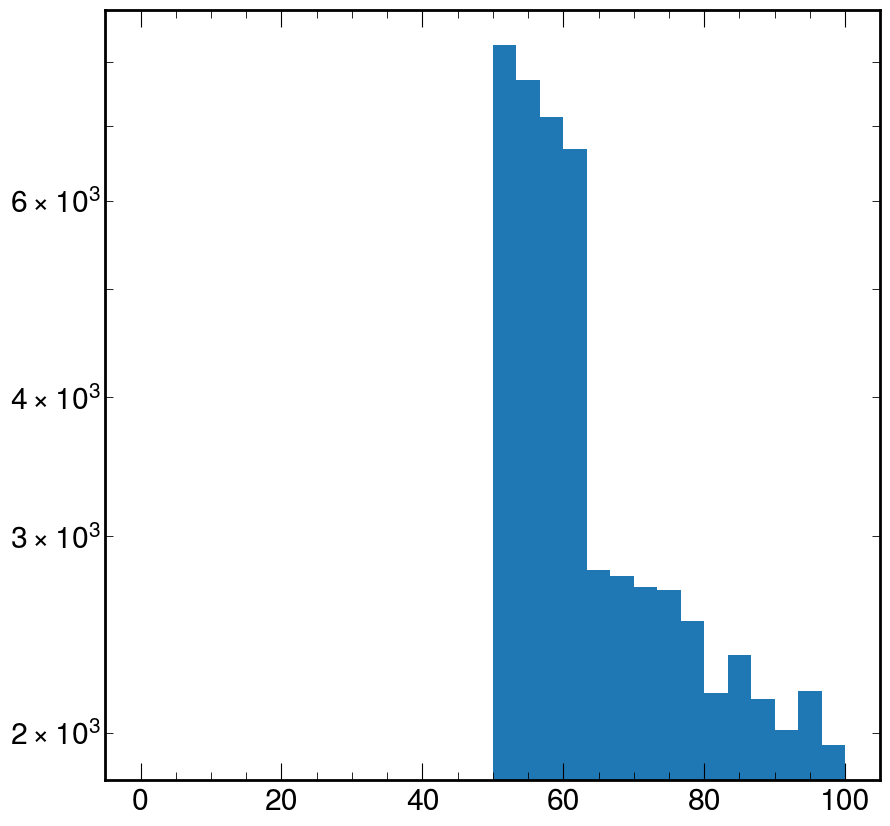

In [113]:
plt.hist(np.concatenate(energy),bins=30,range=(0,100))
plt.yscale('log')

In [4]:
# Will likely need to change name of npz file for your use case
npz_unpacked = np.load(path+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']

targets_theta = np.degrees(targets_unnormalized["theta"])
targets_phi = np.degrees(targets_unnormalized["phi"])
predictions_theta = np.degrees(predictions_unnormalized["theta"])
predictions_phi = np.degrees(predictions_unnormalized["phi"])

In [116]:
file_and_eventnumber_to_index = {}
file_names = meta[:, 0]
unique_file_names = np.unique(file_names)
for unique_name in unique_file_names:
    file_and_eventnumber_to_index[unique_name] = {}
for i, (file_name, event_number, particle_type) in enumerate(meta):
    file_and_eventnumber_to_index[file_name][event_number] = i


# Regex to split base and last number
pattern = re.compile(r'(.+?)_(\d+)\.root$')

# Keep only files that match
matching_files = [f for f in unique_file_names if pattern.search(f)]

# Sort first by base, then by last number
sorted_files = sorted(
    matching_files, 
    key=lambda f: (
        pattern.search(f).group(1),          # base part
        int(pattern.search(f).group(2))      # last number
    )
)

In [125]:
output_data = {}
for i, file_name in enumerate(sorted_files):
    if 'free' not in file_name: continue
    num_events = len(meta[:,0][meta[:,0]==file_name])
    gnn_preds, gnn_truths = [], []
    for event_number in range(num_events):
        # Find the global index for this (file, event_number)
        idx = file_and_eventnumber_to_index[file_name].get(f"{int(event_number)}", None)
        if idx is None:
            gnn_preds.append(None)
            #gnn_truths.append(None)# skip if event isn't in meta_info
        
        gnn_preds.append(predictions_theta[idx])
        #gnn_truths.append(GNN_truth[idx])
    output_data[f"{file_name.split('/')[-1]}"] = ak.Array(gnn_preds)
    #output_data["GNN_true_theta"] = ak.Array(gnn_truths)

In [133]:
flattened = np.concatenate([arr for arr in output_data.values()])

In [135]:
dg['GNN_theta'] = flattened

In [137]:
dg

detector  theta_reco    phi_reco  theta_true    phi_true  \
0              0   33.500357   71.155511   39.802012   59.988974   
1              0   48.451311  112.500000   36.276711  116.456960   
2              0   26.153173 -157.500000   30.339367 -150.249913   
3              0   67.870069  112.500000   74.176018  -43.531968   
4              0   32.736450  -90.000000   43.858596 -101.505043   
...          ...         ...         ...         ...         ...   
295989         3   38.587140   22.500000   36.137578   39.115665   
295990         3   48.450156   -0.000000   34.955609   21.153486   
295991         3   34.383715 -135.000000   45.440004 -141.175488   
295992         3   14.957216   90.000000   15.428585   92.079096   
295993         3   32.480227   22.726889   28.051049   22.790440   

        event_energy  theta_energy  GNN_theta  
0           0.002496     44.018874  31.403015  
1           0.003104     36.008263  37.085255  
2           0.006179     17.528586  22.704494  
3           0.001122           NaN  55.041126  
4           0.003259     34.436134  32.830730  
...              ...           ...        ...  
295989      0.003012     42.215763  16.534536  
295990      0.006236     18.326757  13.456107  
295991      0.003059     41.519185  16.530048  
295992      0.007204     14.682284  12.714511  
295993      0.004084     30.572842  15.283639  

[295994 rows x 8 columns]

In [11]:
import pandas as pd
df = pd.read_pickle(path+'target_merge.pkl')
df

detector  theta_reco    phi_reco  theta_true    phi_true  event_energy  \
0             0   90.000000    0.000000   46.582611  150.326813      0.000437   
1             0   51.817401   71.665004   49.265072   75.083786      0.002958   
2             0   90.000000   90.000000   34.507702  123.674858      0.002324   
3             0   52.277516   90.000000   51.385601   91.222183      0.002918   
4             0   90.000000    0.000000   55.957802  162.828873      0.000412   
...         ...         ...         ...         ...         ...           ...   
13277         2   90.000000   90.000000   51.385601   91.222183      0.001294   
13278         2   22.426010  -14.251689   26.673086  -18.022484      0.000587   
13279         2   22.378701  166.287552   17.672462  153.699463      0.001785   
13280         2   32.631940 -128.659808   27.408253 -132.584503      0.001595   
13281         2   31.294842    9.239153   30.788223   -6.025821      0.001495   

       theta_reco_x  theta_reco_y  
0               inf           NaN  
1     -4.000000e-01     -1.207015  
2               NaN           inf  
3     -8.992441e-17     -1.292800  
4               inf           NaN  
...             ...           ...  
13277           NaN           inf  
13278 -4.000000e-01      0.101600  
13279  4.000000e-01     -0.097602  
13280  4.000000e-01      0.500000  
13281 -6.000000e-01     -0.097600  

[13282 rows x 8 columns]

In [6]:
import pandas as pd
dg = pd.read_pickle(path+'free_merge.pkl')
dg

detector  theta_reco    phi_reco  theta_true    phi_true  event_energy  \
0             0   16.530888   90.000000   22.065199   85.454552      0.001362   
1             0   31.322241   -9.610915   33.935493   -2.784942      0.001621   
2             0   90.000000   90.000000   57.531021  158.412506      0.000756   
3             0   28.303196 -111.801409   25.116611 -111.557327      0.001147   
4             0   12.546367  153.987623   12.422194  139.527664      0.001866   
...         ...         ...         ...         ...         ...           ...   
24303         2   26.587035 -143.056941   27.408253 -132.584503      0.000817   
24304         2    5.574390   90.000000   13.165565   87.344124      0.000249   
24305         2   90.000000   90.000000   47.312649   59.999992      0.002244   
24306         2   19.692167   56.025835   22.226591   47.475941      0.002245   
24307         2   12.546357   26.012286   17.835608   29.272236      0.001228   

       theta_reco_x  theta_reco_y  
0      1.170747e-16     -0.296800  
1     -6.000000e-01      0.101600  
2               NaN           inf  
3      2.000000e-01      0.500000  
4      2.000000e-01     -0.097600  
...             ...           ...  
24303  4.000000e-01      0.300799  
24304 -1.138394e-16     -0.097600  
24305           NaN           inf  
24306 -2.000000e-01     -0.296801  
24307 -2.000000e-01     -0.097600  

[24308 rows x 8 columns]

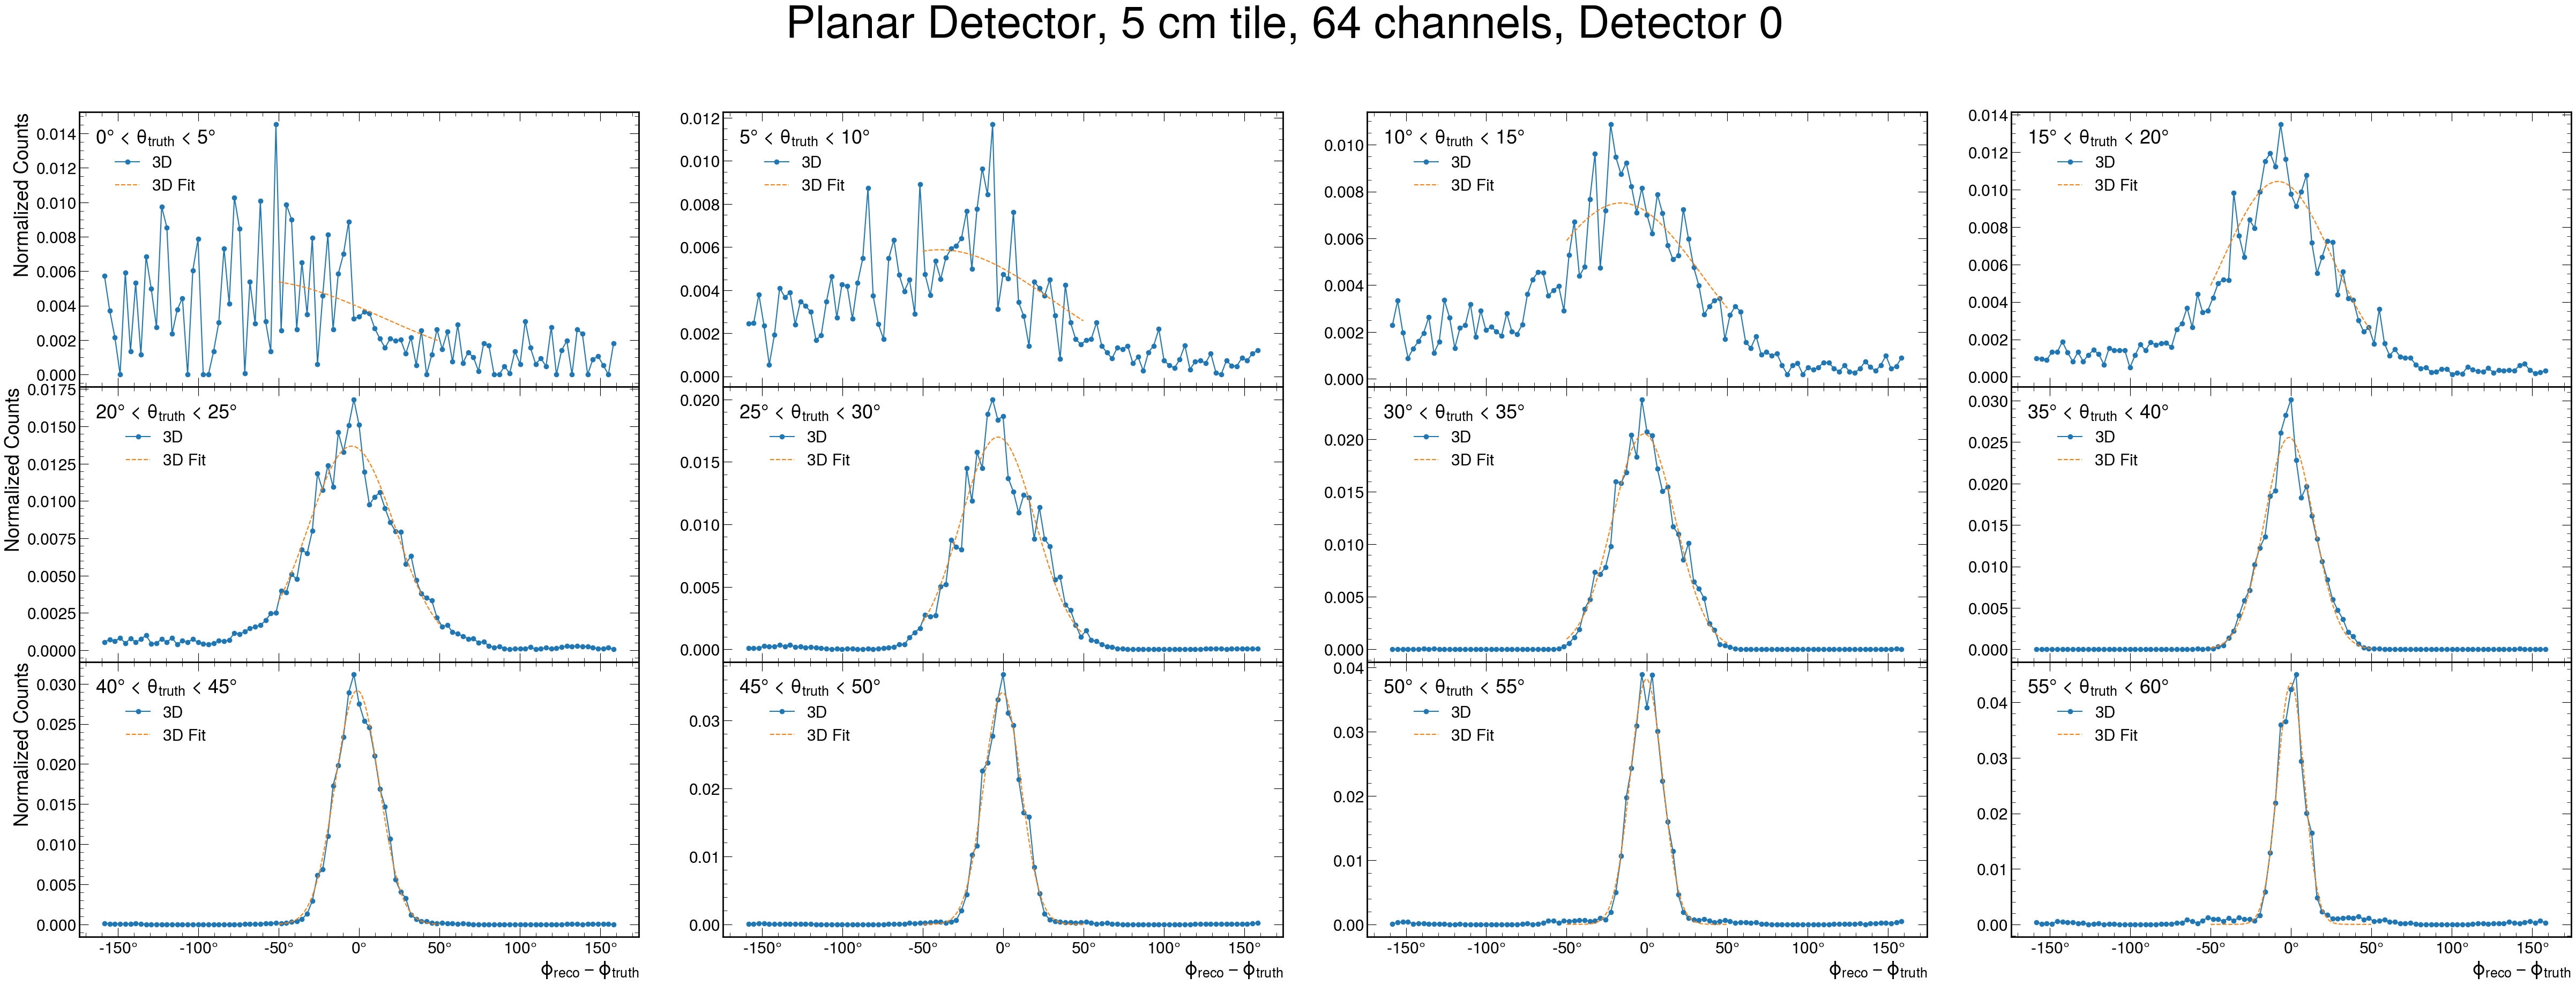

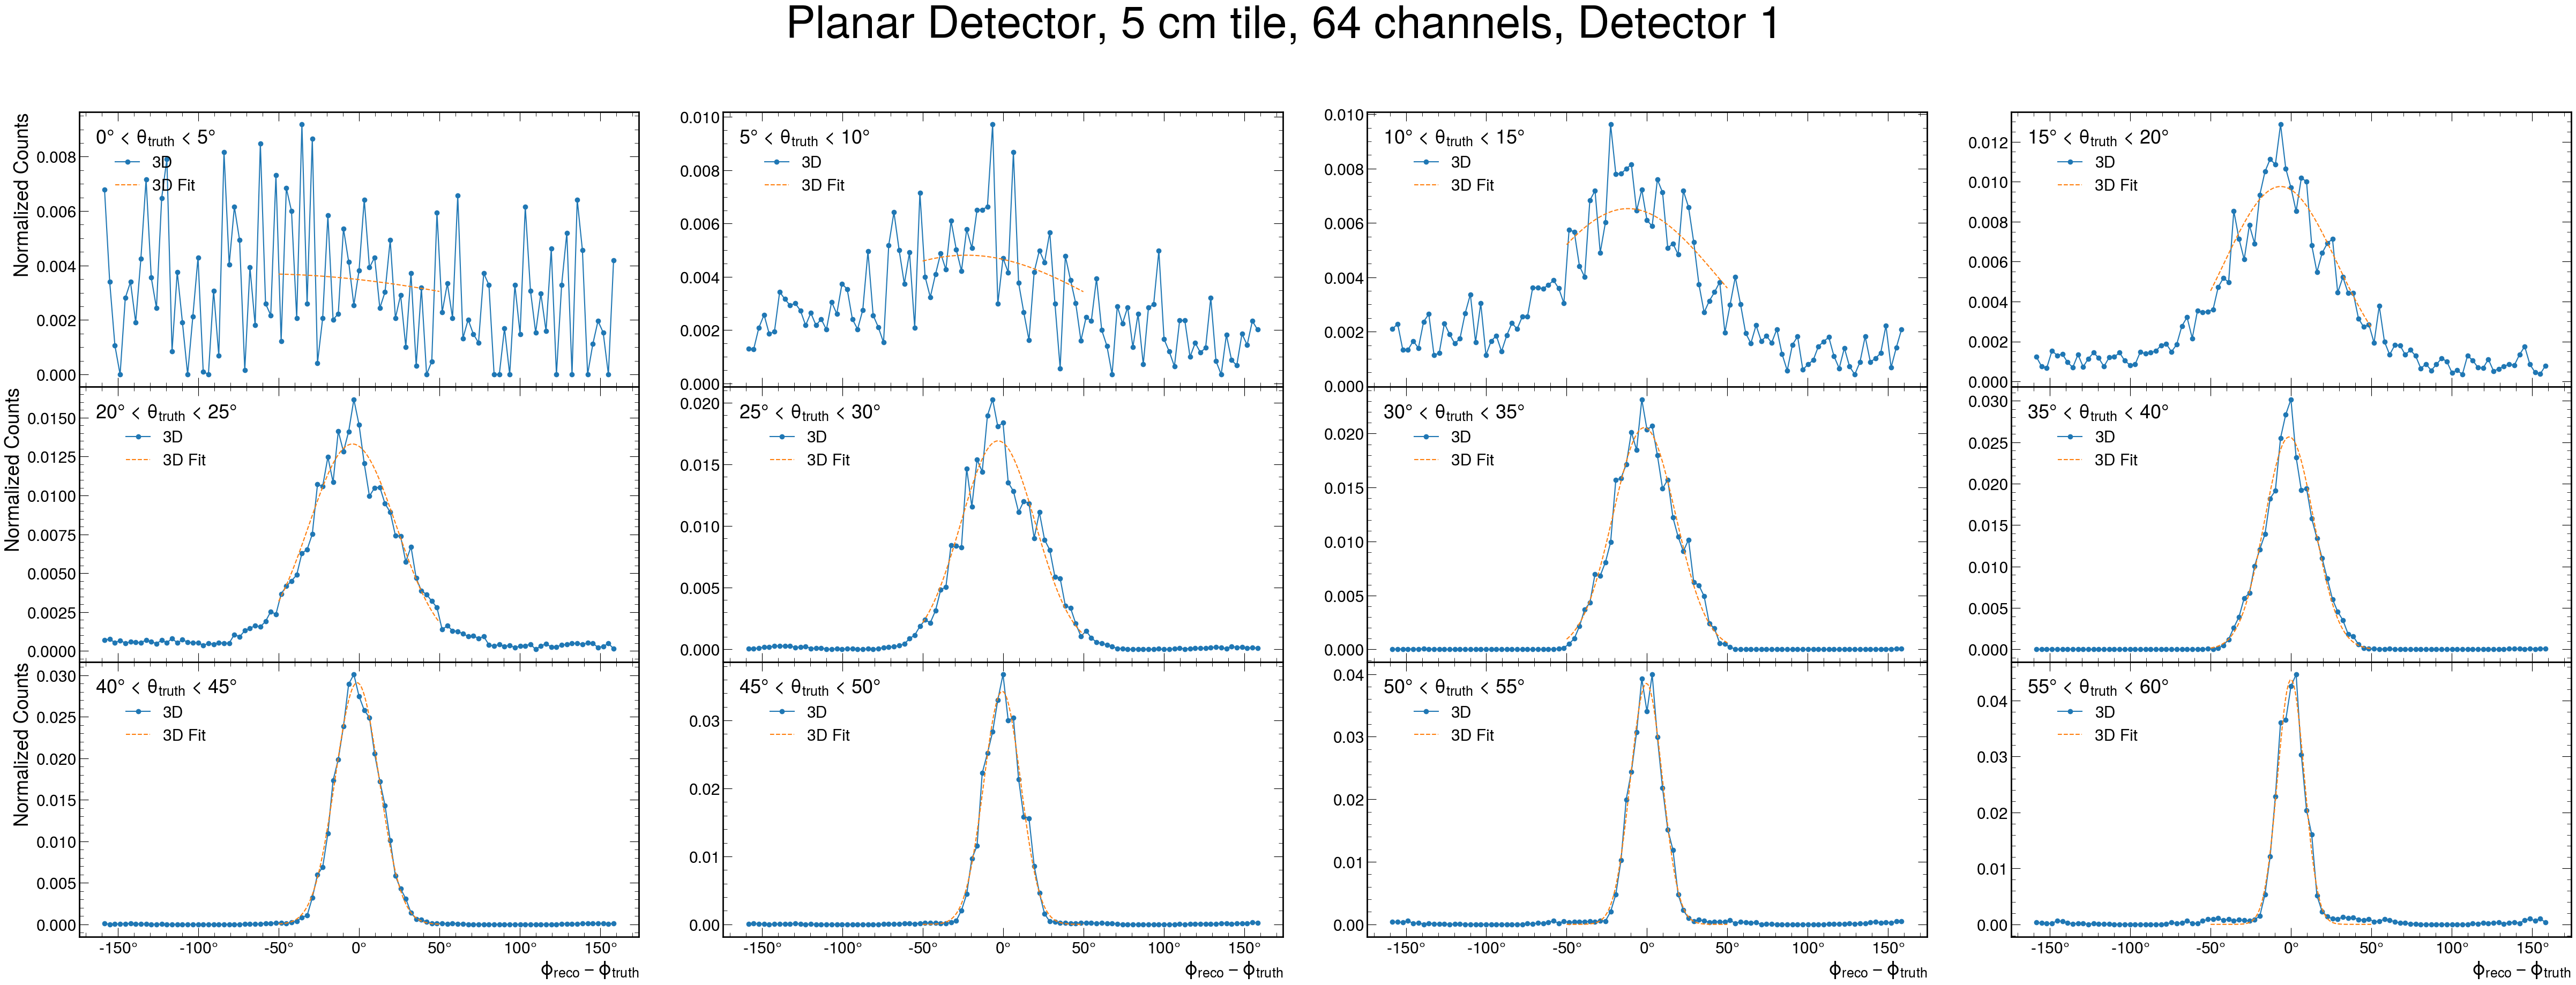

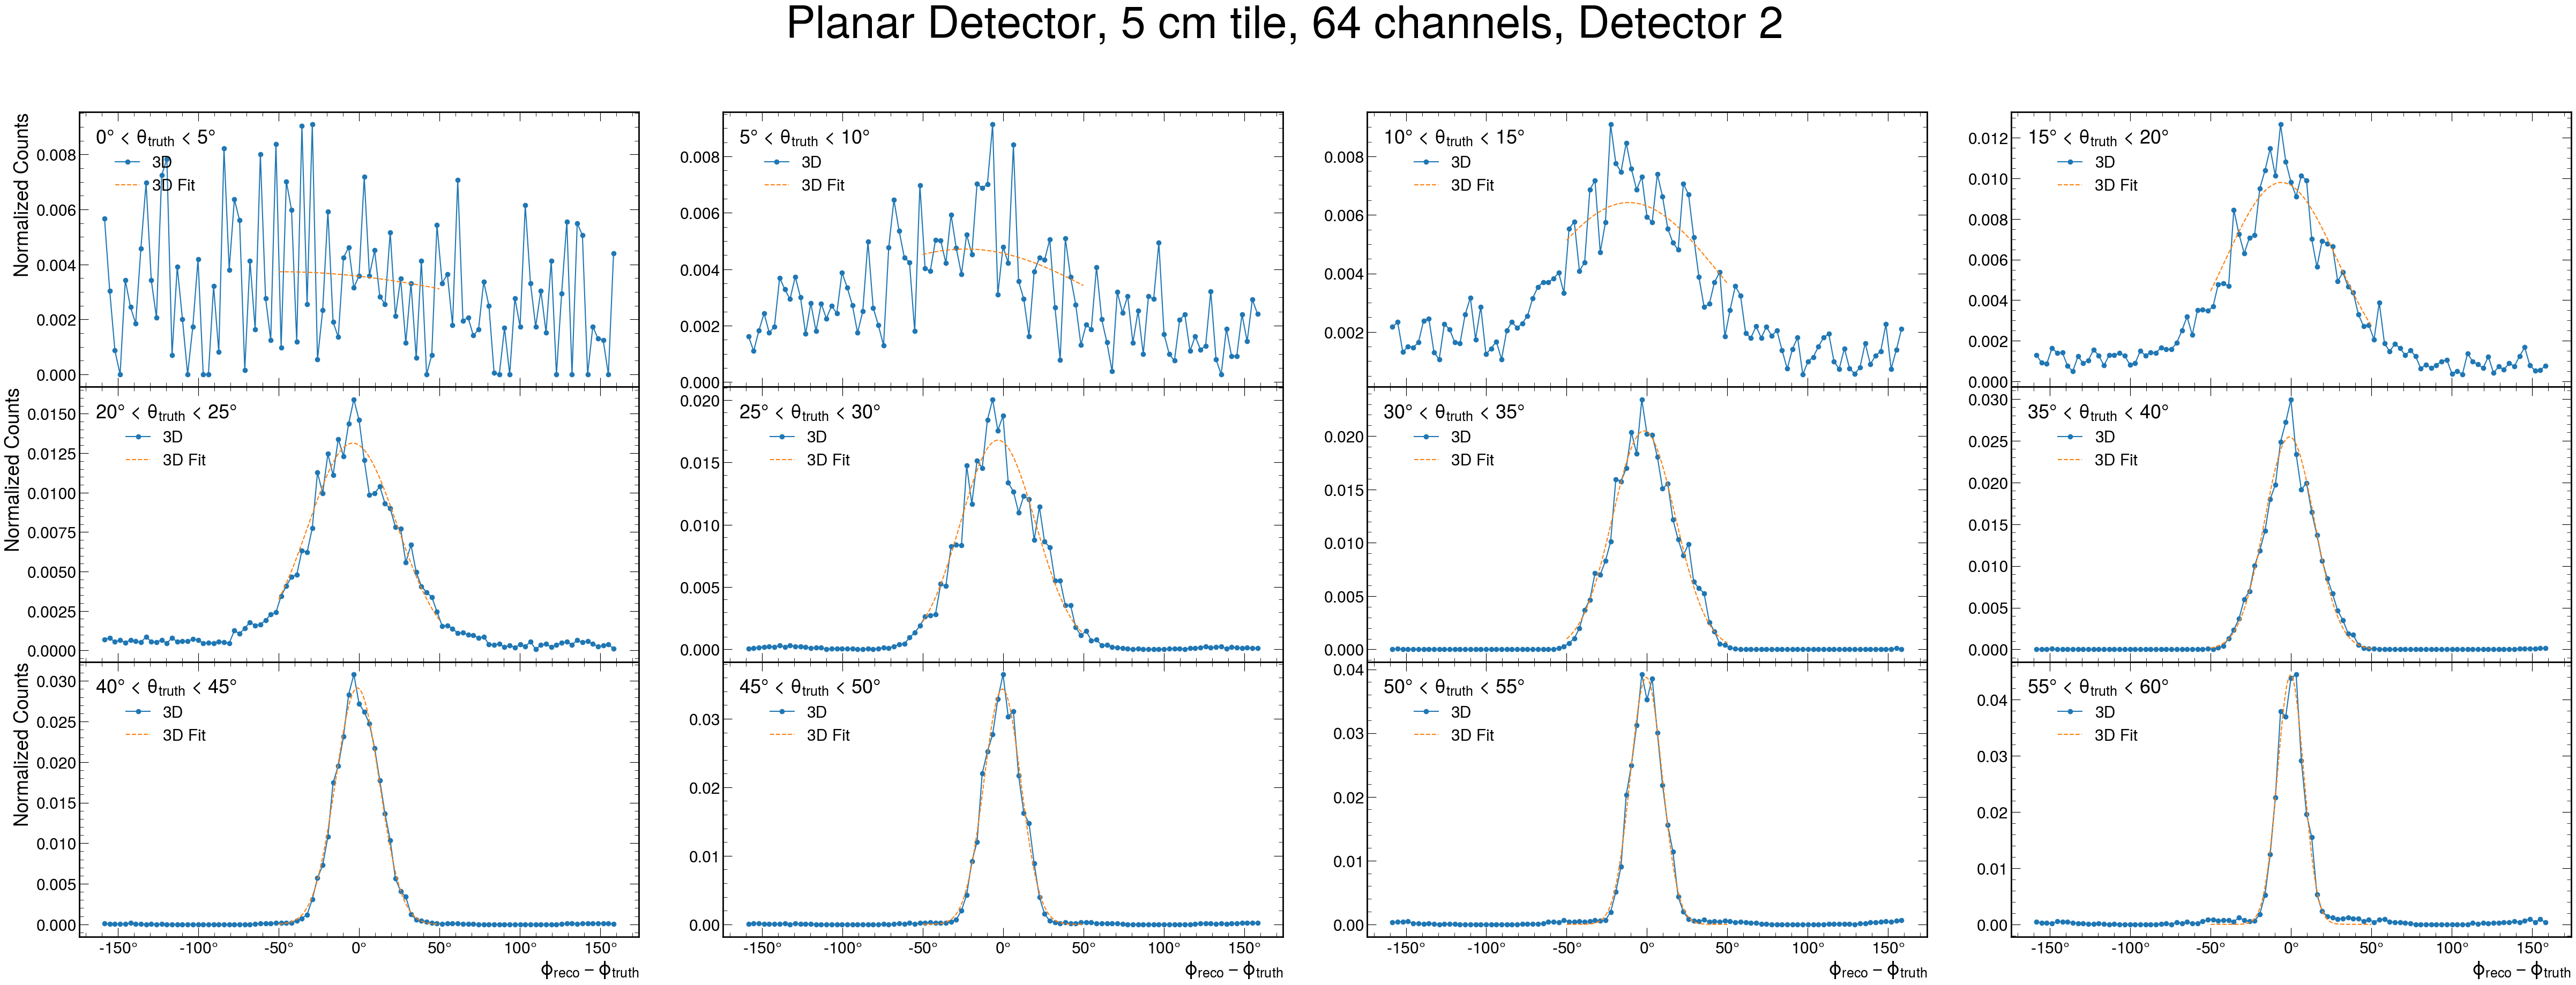

In [83]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 5
bins= []
rms = []
mea = []
fits = []
error = []
binnum = np.linspace(-160,160,100)
max_bin = 65
for j in range(3):
    fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)

    for i in range(12):
        plt.sca(ax[i//4,i%4])
        bins.append(i*binsize+5+binsize/2)
        detector_cut = df['detector']==j
        cut = (((i) * binsize <= df['theta_true'][detector_cut]) & (df['theta_true'][detector_cut] < (i+1) * binsize))
        '''
        y,x = np.histogram(df['GNN_phi'][detector_cut][cut]-df['phi_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='GNN')
        means = df['GNN_phi'][detector_cut][cut]-df['phi_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))
        
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100))
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-50,50,100)
        #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='GNN Fit')
        '''
        y,x = np.histogram(df['phi_reco'][detector_cut][cut]-df['phi_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='3D')
        means = df['phi_reco'][detector_cut][cut]-df['phi_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))

        try:
            coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100))
            fits.append(coeff)
            error.append(covar[2][2])
            x=np.linspace(-50,50,100)
            plt.errorbar(x,gaus(x,*coeff),fmt='--',label='3D Fit')
        except: 
            fits.append([0,0,0])
            error.append(0)
        plt.xlabel(r'$\phi_{reco} - \phi_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{truth}}$ < {(i+1) * binsize}$\degree$', loc = 'upper left')
        #plt.xlim(-50,50)
    fig.subplots_adjust(wspace=0.15,hspace=0)
    
    ax[0,0].set_ylabel('Normalized Counts')
    ax[1,0].set_ylabel('Normalized Counts')
    ax[2,0].set_ylabel('Normalized Counts')
    
    import matplotlib.ticker as mticker
    def degree_formatter(x, pos):
        return rf"{int(x)}$\degree$" 
    for axi in ax.flat:
        axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))
    
    #plt.savefig('ThetaResolution_differential.pdf',format='pdf')
    plt.suptitle(f'Planar Detector, 5 cm tile, 64 channels, Detector {j}', fontsize=60)
    plt.show()

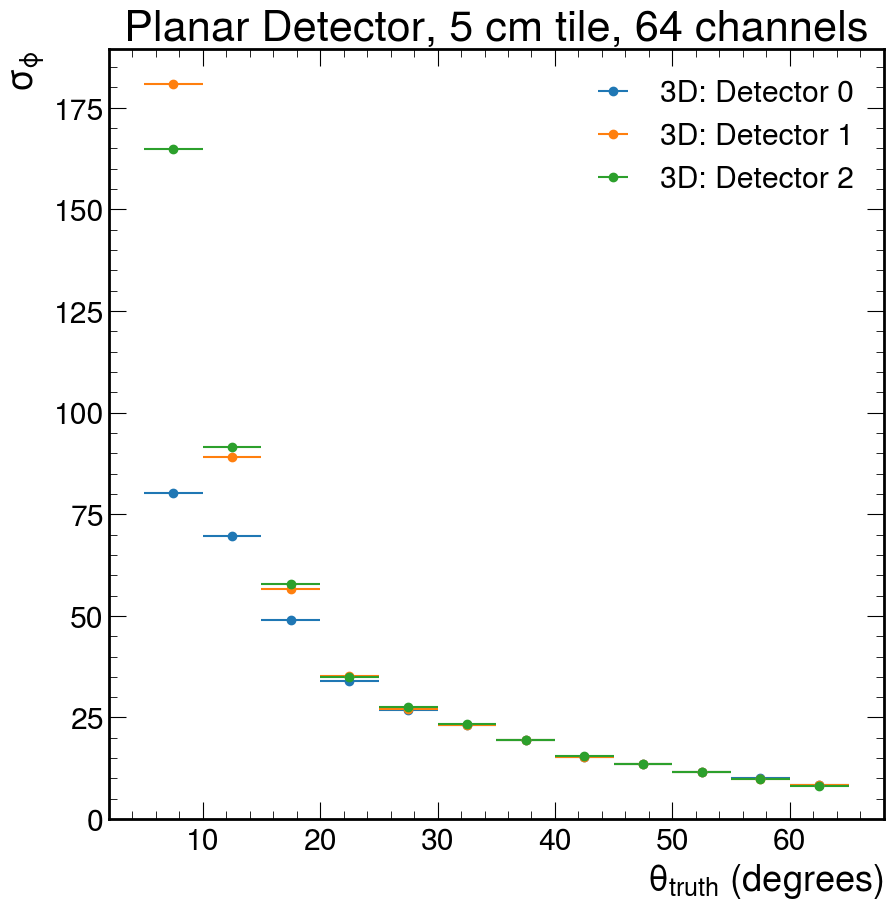

In [68]:
for j in range(3):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,2][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,label=f'3D: Detector {j}',fmt='o')
#plt.errorbar(bins[:11],theta_reco_sigma,xerr=(bins[1]-bins[0])/2,label=f'GNN: Model',fmt='*')
plt.ylabel(r'$\sigma_{\phi}$')
plt.ylim(bottom=0)
plt.xlabel(r'$\theta_{{truth}}$ (degrees)')

plt.legend()
plt.title('Planar Detector, 5 cm tile, 64 channels')
plt.savefig('ThetaResolution_sigma.png',format='png')

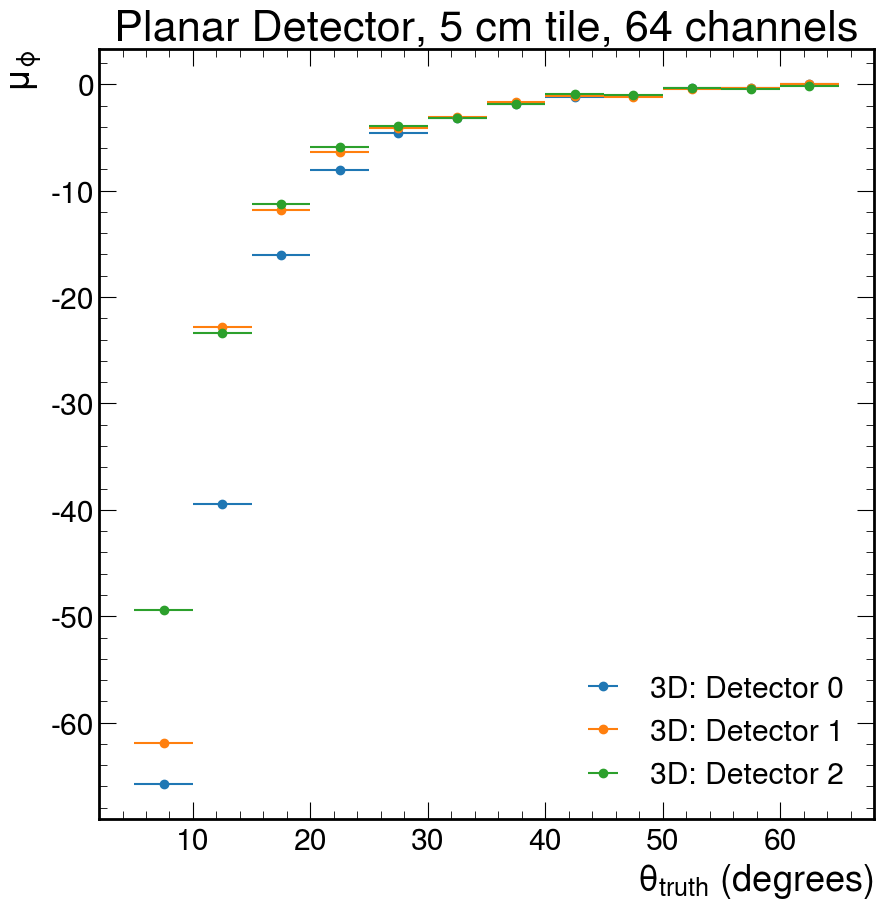

In [69]:
for j in range(3):
    plt.errorbar(bins[:12],np.array(fits)[:,1][j*12:(j+1)*12],xerr=(bins[1]-bins[0])/2,label=f'3D: Detector {j}',fmt='o')
#plt.errorbar(bins[:11],theta_mean,xerr=(bins[1]-bins[0])/2,label=f'GNN: Model',fmt='*')

plt.ylabel(r'$\mu_{\phi}$')
#plt.ylim(bottom=-10,top=10)
plt.legend()
plt.xlabel(r'$\theta_{{truth}}$ (degrees)')

plt.title('Planar Detector, 5 cm tile, 64 channels')
plt.savefig('ThetaResolution_mu.png',format='png')

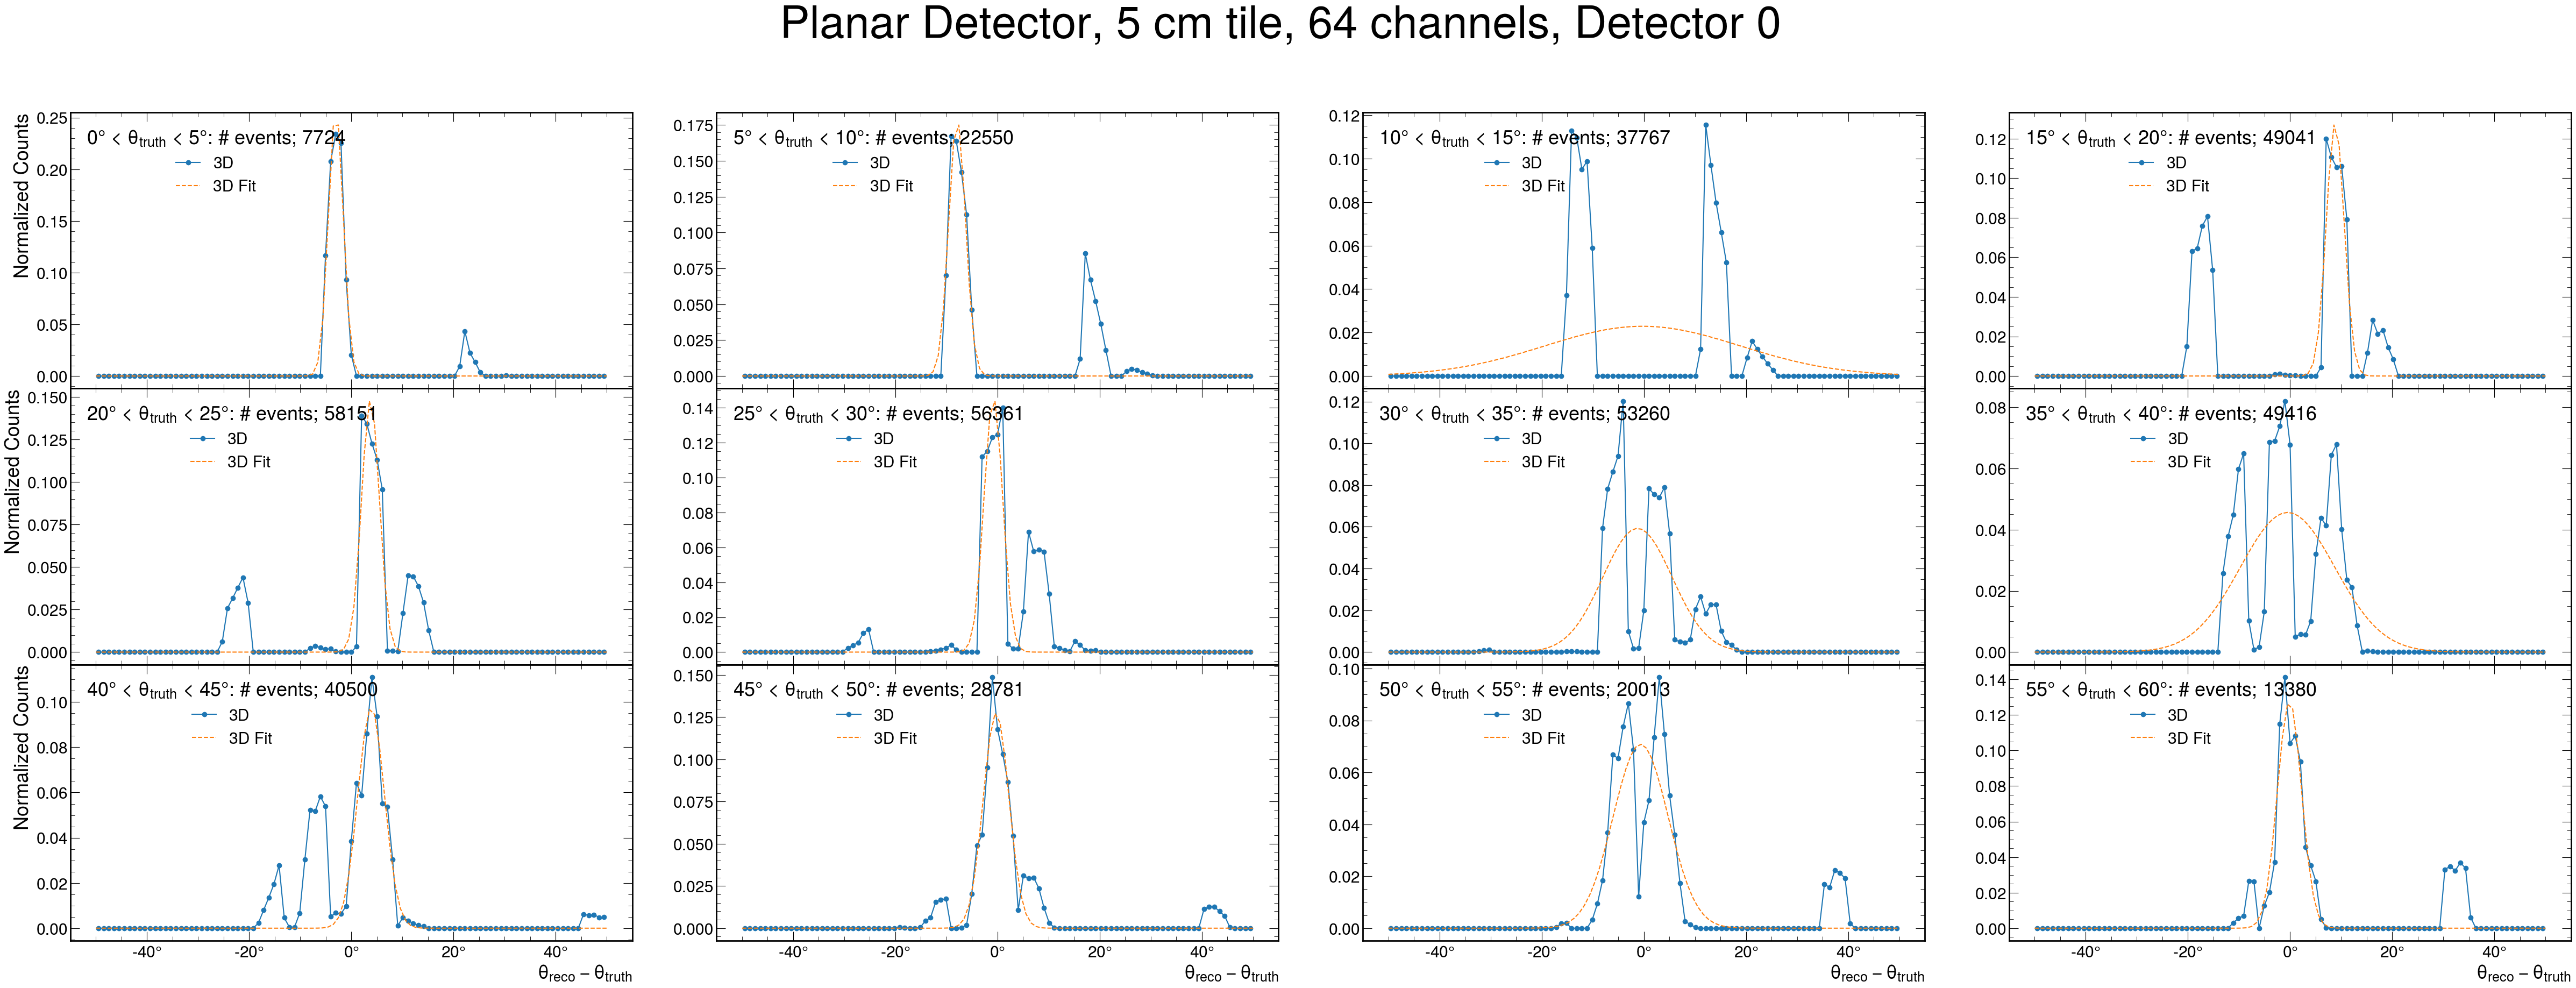

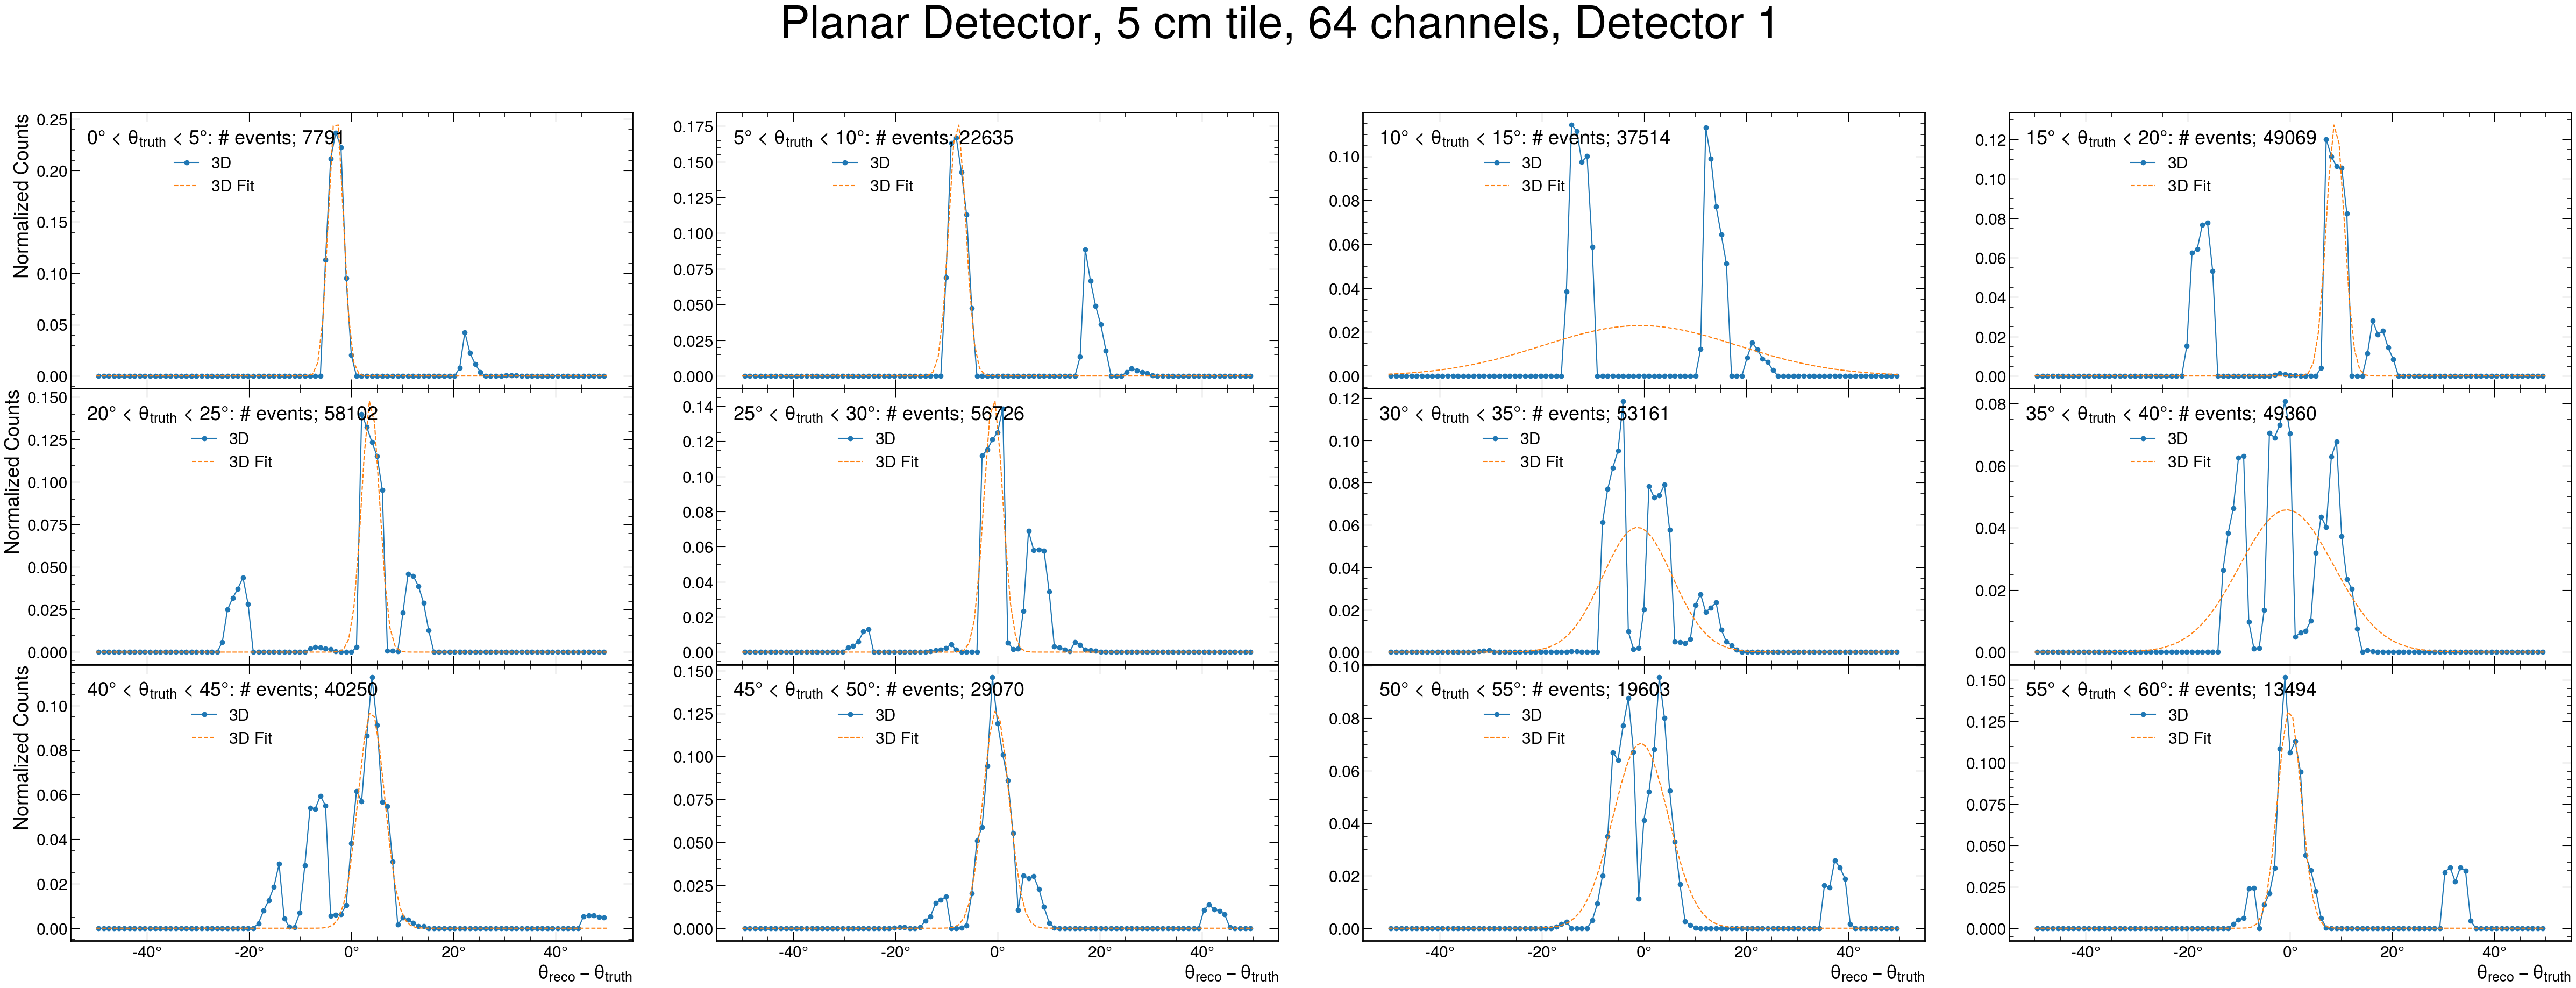

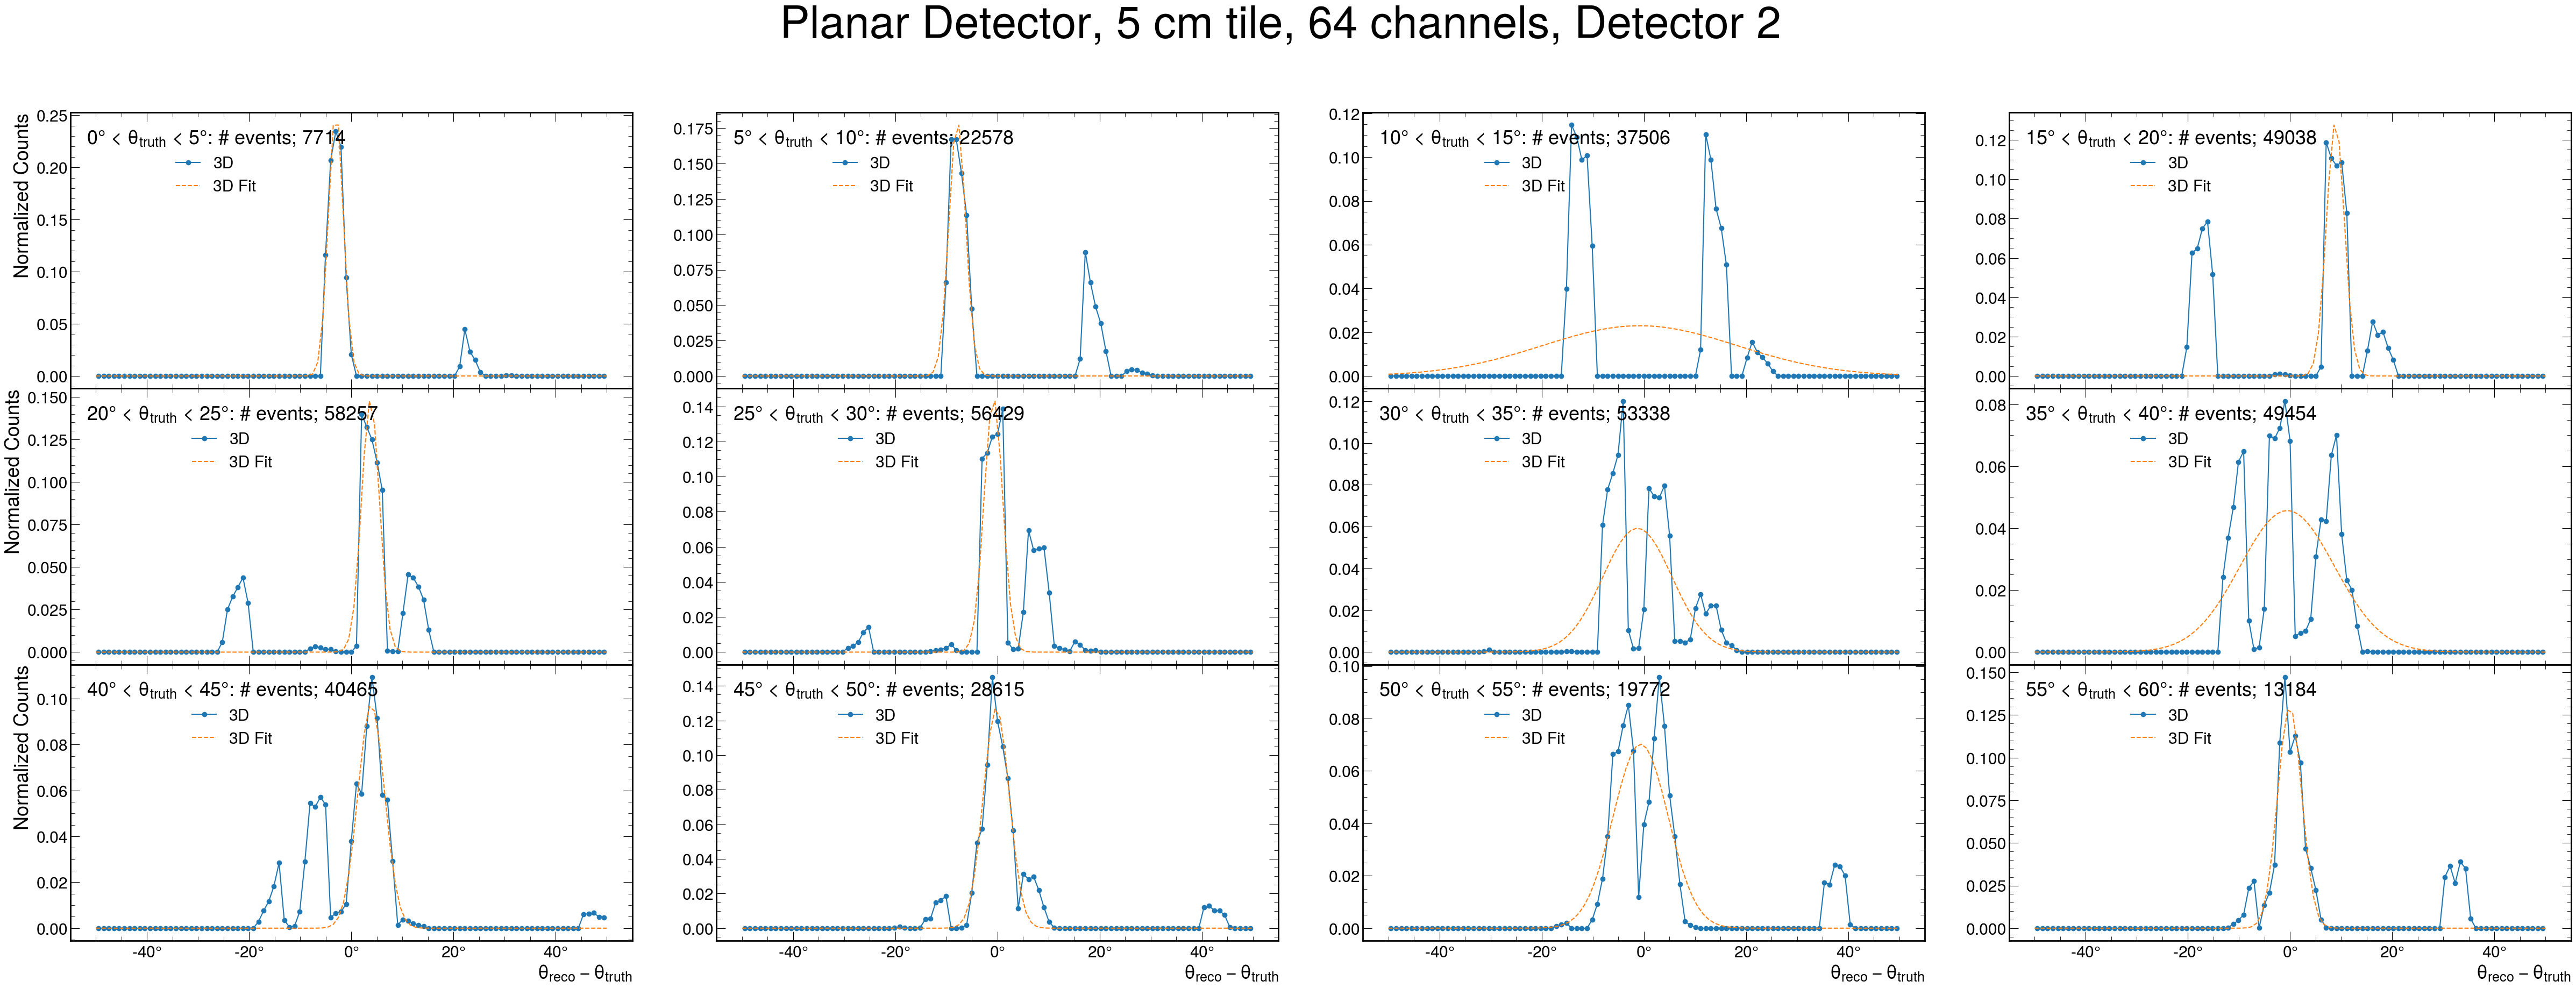

In [70]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 5
bins= []
rms = []
mea = []
fits = []
error = []
det = []
binnum = np.linspace(-50,50,100)
max_bin = 65
for j in range(3):
    
    fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)

    for i in range(12):
        plt.sca(ax[i//4,i%4])
        bins.append(i*binsize+5+binsize/2)
        detector_cut = df['detector']==j
        cut = (((i) * binsize <= df['theta_true'][detector_cut]) & (df['theta_true'][detector_cut] < (i+1) * binsize))
        '''
        y,x = np.histogram(df['GNN_theta'][detector_cut][cut]-df['theta_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='GNN')
        means = df['GNN_theta'][detector_cut][cut]-df['theta_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))
        
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100))
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-50,50,100)
        #plt.errorbar(x,gaus(x,*coeff),fmt='--',label='GNN Fit')
        '''
        y,x = np.histogram(df['theta_reco'][detector_cut][cut]-df['theta_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='3D')
        means = df['theta_reco'][detector_cut][cut]-df['theta_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))
        try:
            coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100))
            det.append(j)
            fits.append(coeff)
            error.append(covar[2][2])
            plt.errorbar(x,gaus(x,*coeff),fmt='--',label='3D Fit')
        except: 
            det.append(j)
            fits.append([0,0,0])
            error.append(0)
        plt.xlabel(r'$\theta_{reco} - \theta_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{truth}}$ < {(i+1) * binsize}$\degree$: # events; {len(cut[cut])}', loc = 'upper left')
        #plt.xlim(-50,50)
    fig.subplots_adjust(wspace=0.15,hspace=0)
    
    ax[0,0].set_ylabel('Normalized Counts')
    ax[1,0].set_ylabel('Normalized Counts')
    ax[2,0].set_ylabel('Normalized Counts')
    
    import matplotlib.ticker as mticker
    def degree_formatter(x, pos):
        return rf"{int(x)}$\degree$" 
    for axi in ax.flat:
        axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))
    
    plt.savefig('ThetaResolution_differential.pdf',format='pdf')
    plt.suptitle(f'Planar Detector, 5 cm tile, 64 channels, Detector {j}', fontsize=60)
    plt.show()

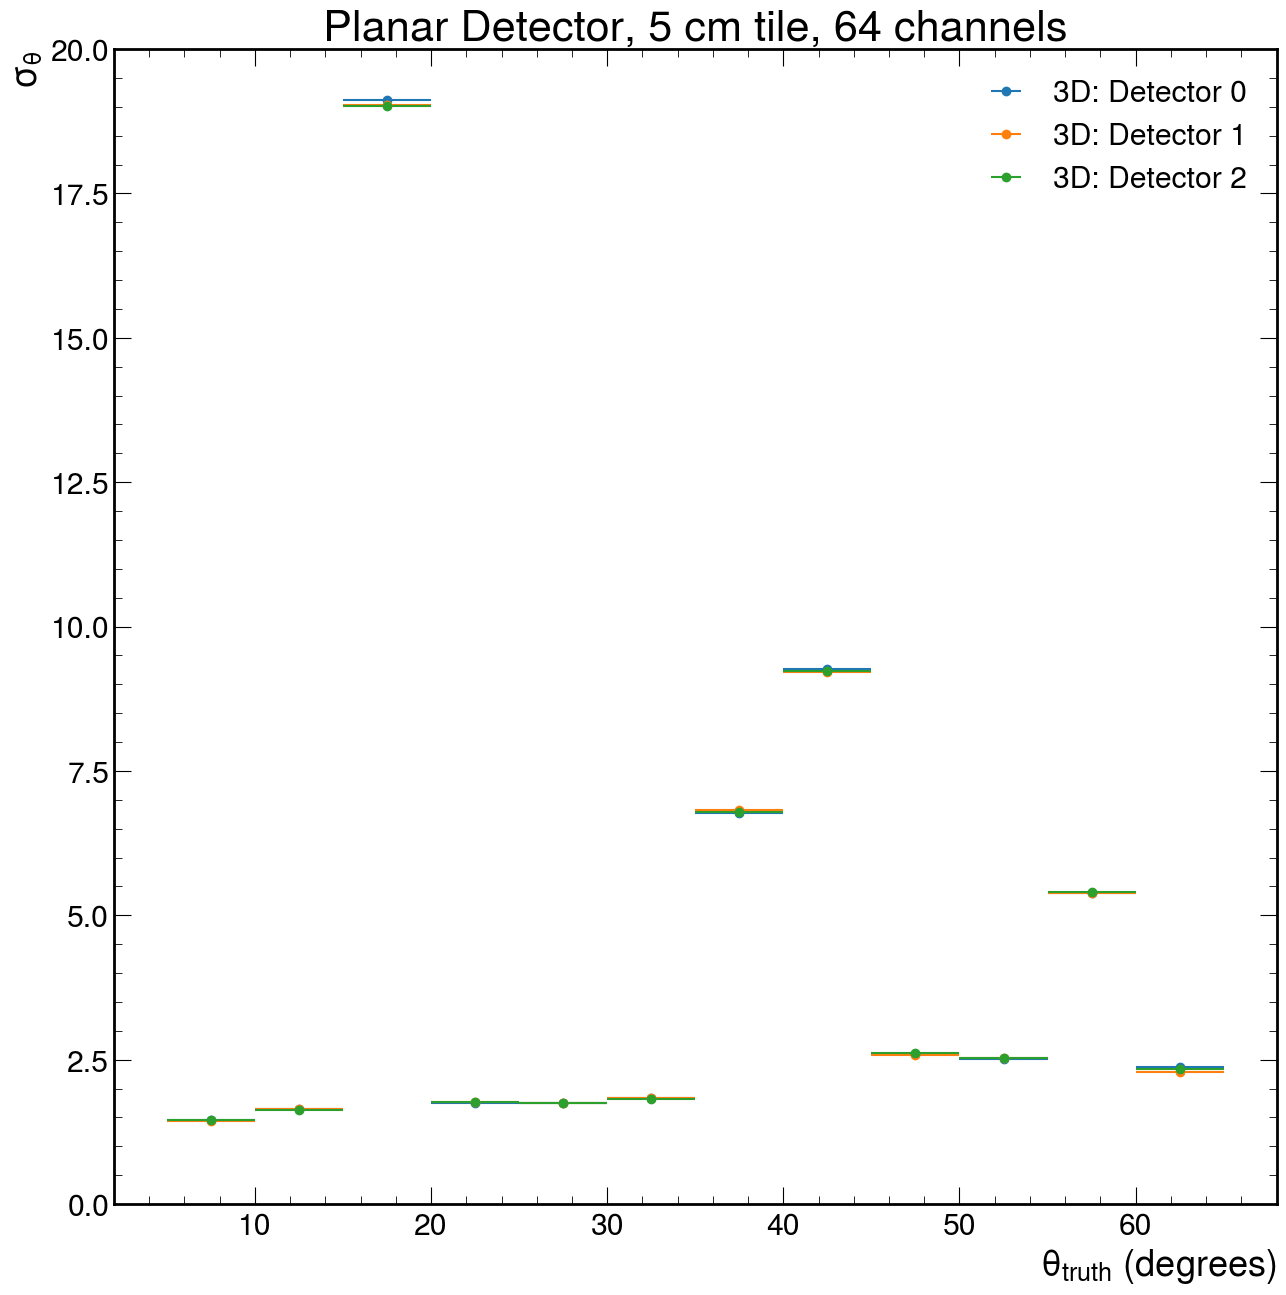

In [71]:
plt.figure(figsize=(15,15))
for j in range(3):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,2][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,label=f'3D: Detector {j}',fmt='o')
#plt.errorbar(bins[:11],theta_reco_sigma,xerr=(bins[1]-bins[0])/2,label=f'GNN: Model',fmt='*')
plt.ylabel(r'$\sigma_{\theta}$')
plt.ylim(bottom=0,top=20)
plt.title('Planar Detector, 5 cm tile, 64 channels')
plt.xlabel(r'$\theta_{{truth}}$ (degrees)')
plt.legend()
plt.savefig('ThetaResolution_sigma.png',format='png')

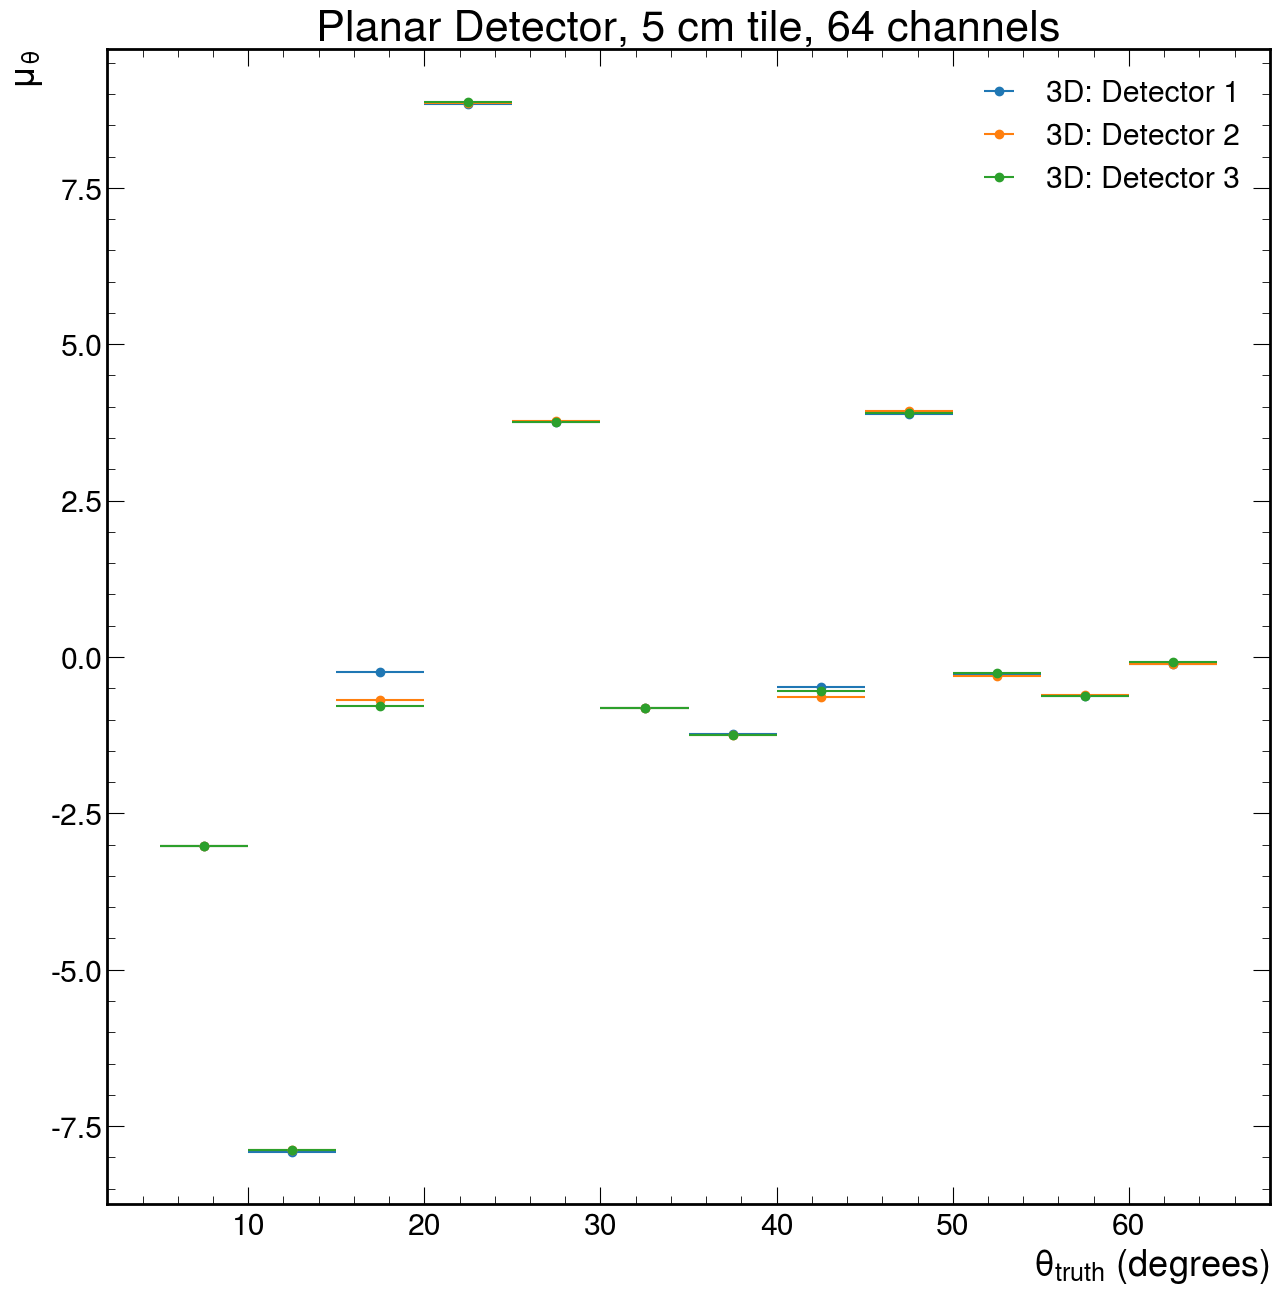

In [72]:
plt.figure(figsize=(15,15))
for j in range(3):
    plt.errorbar(bins[:12],np.array(fits)[:,1][j*12:(j+1)*12],xerr=(bins[1]-bins[0])/2,label=f'3D: Detector {j+1}',fmt='o')
#plt.errorbar(bins[:11],theta_mean,xerr=(bins[1]-bins[0])/2,label=f'GNN: Model',fmt='*')

plt.ylabel(r'$\mu_{\theta}$')
#plt.ylim(bottom=0)
plt.title('Planar Detector, 5 cm tile, 64 channels')
plt.legend()
plt.xlabel(r'$\theta_{{truth}}$ (degrees)')

plt.savefig('ThetaResolution_mu.png',format='png')

In [52]:
num = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    num.append(len(dg['detector'][dg['detector']==i]))

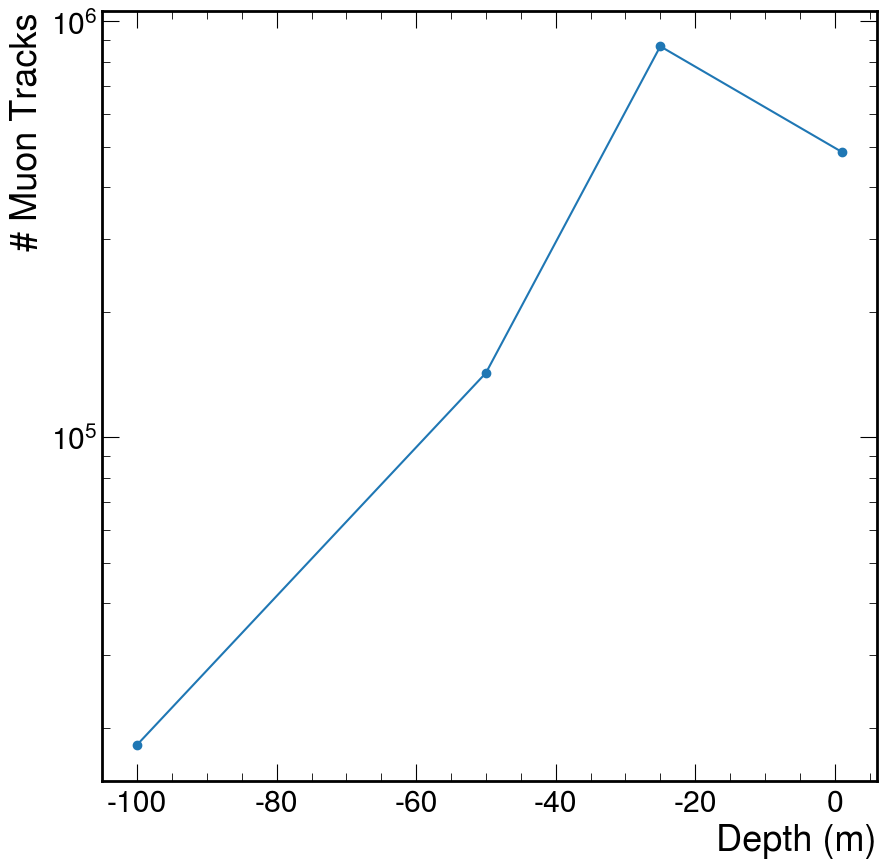

In [53]:
plt.errorbar([1,-25,-50,-100],num[:4],yerr=np.sqrt(num[:4]),fmt='-o')

plt.xlabel('Depth (m)')
plt.ylabel('# Muon Tracks')
plt.yscale('log')

In [54]:
num

[485732, 871063, 142892, 18255, 871604, 142397, 18455, 870263, 142587, 18312]

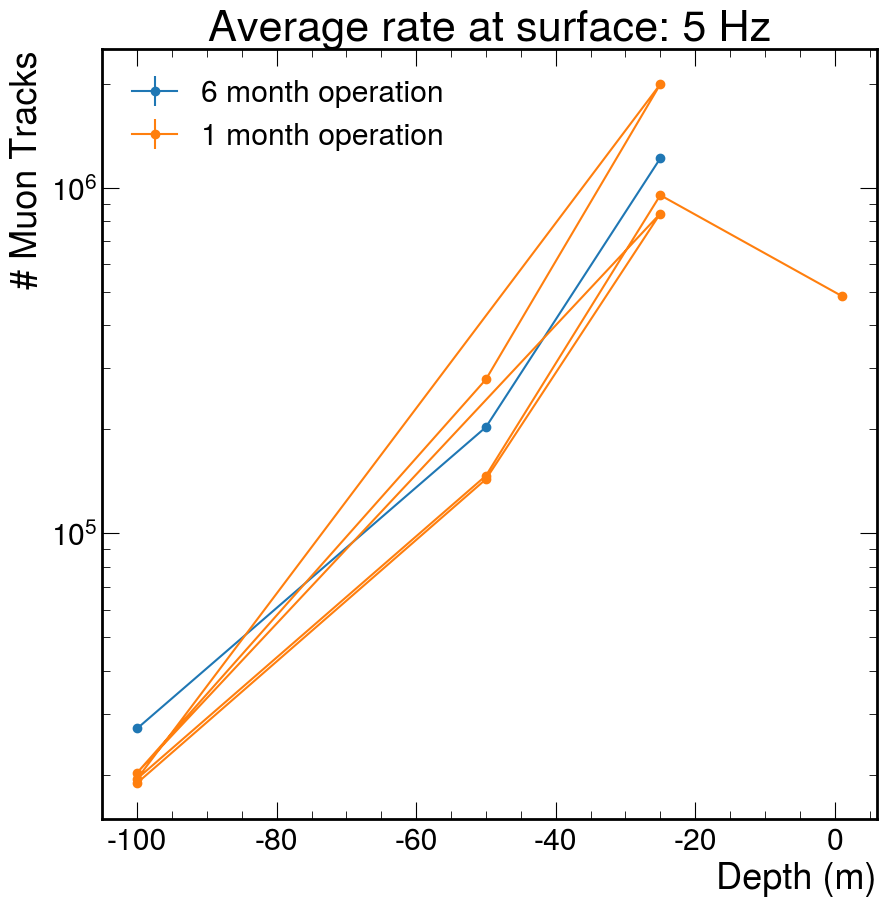

In [50]:
sim_len = [64381,699,93,27,9]
plt.errorbar([-25,-50,-100],[1216686, 202712, 27192],yerr=np.sqrt([1216686, 202712, 27192]),fmt='-o',label='6 month operation')
plt.errorbar([1,-25,-50,-100,-25,-50,-100,-25,-50,-100],np.array(num),yerr=np.sqrt(num),fmt='-o',label='1 month operation')

plt.xlabel('Depth (m)')
#plt.ylim(1e-6,100.2)
plt.ylabel('# Muon Tracks')
plt.title('Average rate at surface: 5 Hz')
plt.yscale('log')
plt.legend()

In [53]:
dg

detector  theta_reco    phi_reco  theta_true    phi_true  \
0               0    0.000000 -180.000000    9.186519   95.473755   
1               0   26.565051 -180.000000   33.454208 -172.419662   
2               0   26.565051 -180.000000   15.703525  169.057938   
3               0    0.000000 -180.000000   20.372868  -48.541641   
4               0   26.473304  -90.000000    6.628536  -95.627563   
...           ...         ...         ...         ...         ...   
1343904         2   35.210468 -135.114653   32.343300 -159.258423   
1343905         2   48.166968   26.473439   49.754883   39.851719   
1343906         2   48.098476 -116.656996   49.031868 -113.106285   
1343907         2   48.166968  153.526561   31.706406  167.080505   
1343908         2   26.473439   90.000000   11.729747  140.109924   

         event_energy  theta_reco_x  theta_reco_y  
0            0.001339  0.000000e+00      0.000000  
1            0.001445  5.000000e-01      0.000000  
2            0.001835  5.000000e-01      0.000000  
3            0.001381  0.000000e+00      0.000000  
4            0.001750 -7.944099e-17      0.498000  
...               ...           ...           ...  
1343904      0.001823  5.000000e-01      0.498003  
1343905      0.001800 -1.000000e+00     -0.498003  
1343906      0.002361  5.000000e-01      0.996001  
1343907      0.001313  1.000000e+00     -0.498003  
1343908      0.002050  1.588820e-16     -0.498003  

[1343909 rows x 8 columns]

Text(1, 0, '$\\theta_{truth}$')

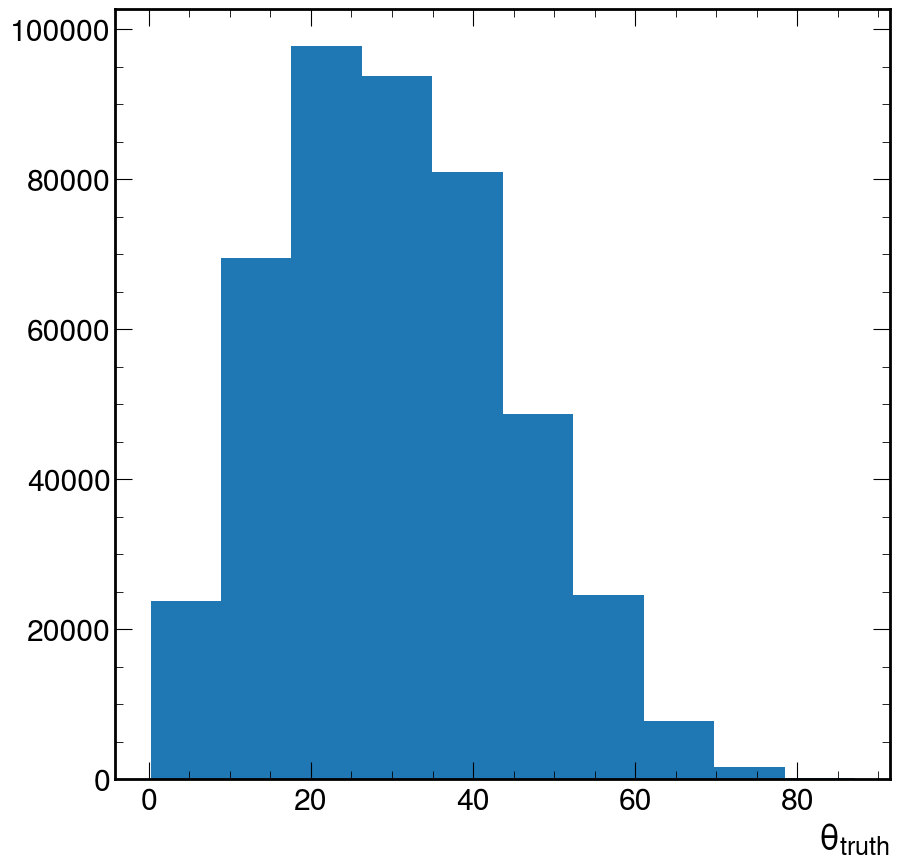

In [65]:
plt.hist(dg['theta_true'][dg['detector']==0])
plt.xlabel(r'$\theta_{truth}$')

In [75]:
np.degrees(np.tan(0.25))

14.630014418727331

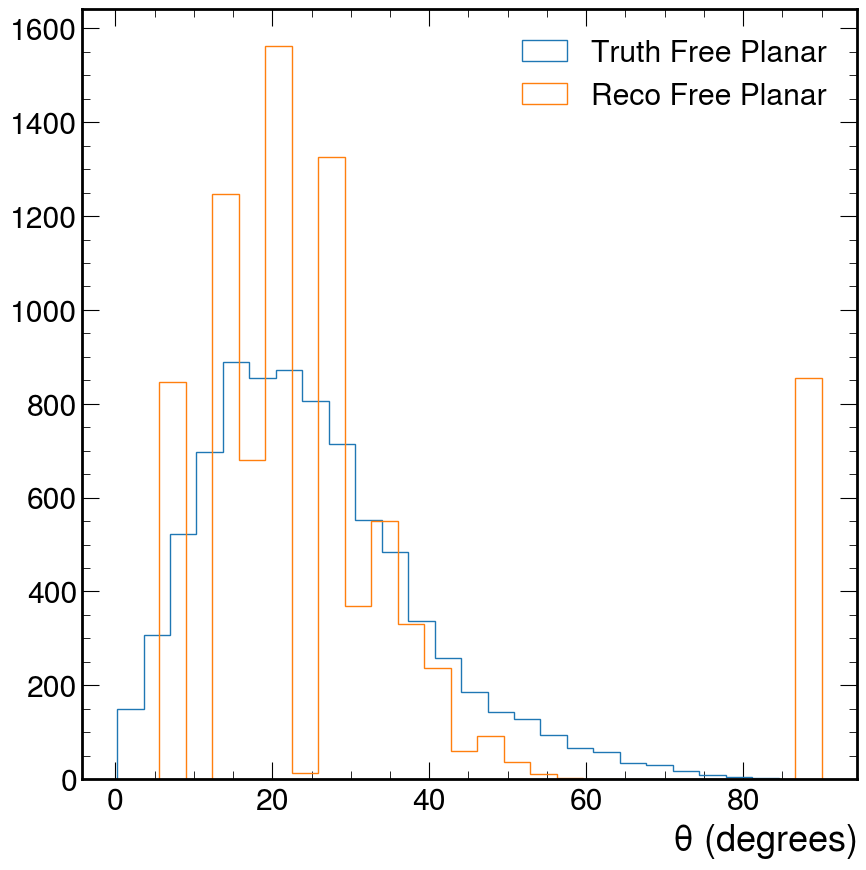

In [10]:
plt.hist(dg['theta_true'][dg['detector']==0],label='Truth Free Planar',histtype='step',bins=25)
plt.hist(dg['theta_reco'][dg['detector']==0],label='Reco Free Planar',histtype='step',bins=25)
plt.xlabel(r'$\theta$ (degrees)')
plt.legend()

In [57]:
r = 1
def spherical_to_xyz(theta, phi, r=r):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

truth_xyz = spherical_to_xyz(dg['theta_true'],dg['phi_true'])
reco_xyz = spherical_to_xyz(dg['theta_reco'],dg['theta_reco'])
diff_xyz = spherical_to_xyz(dg['theta_true']-dg['theta_reco'],dg['phi_true']-dg['theta_reco'])

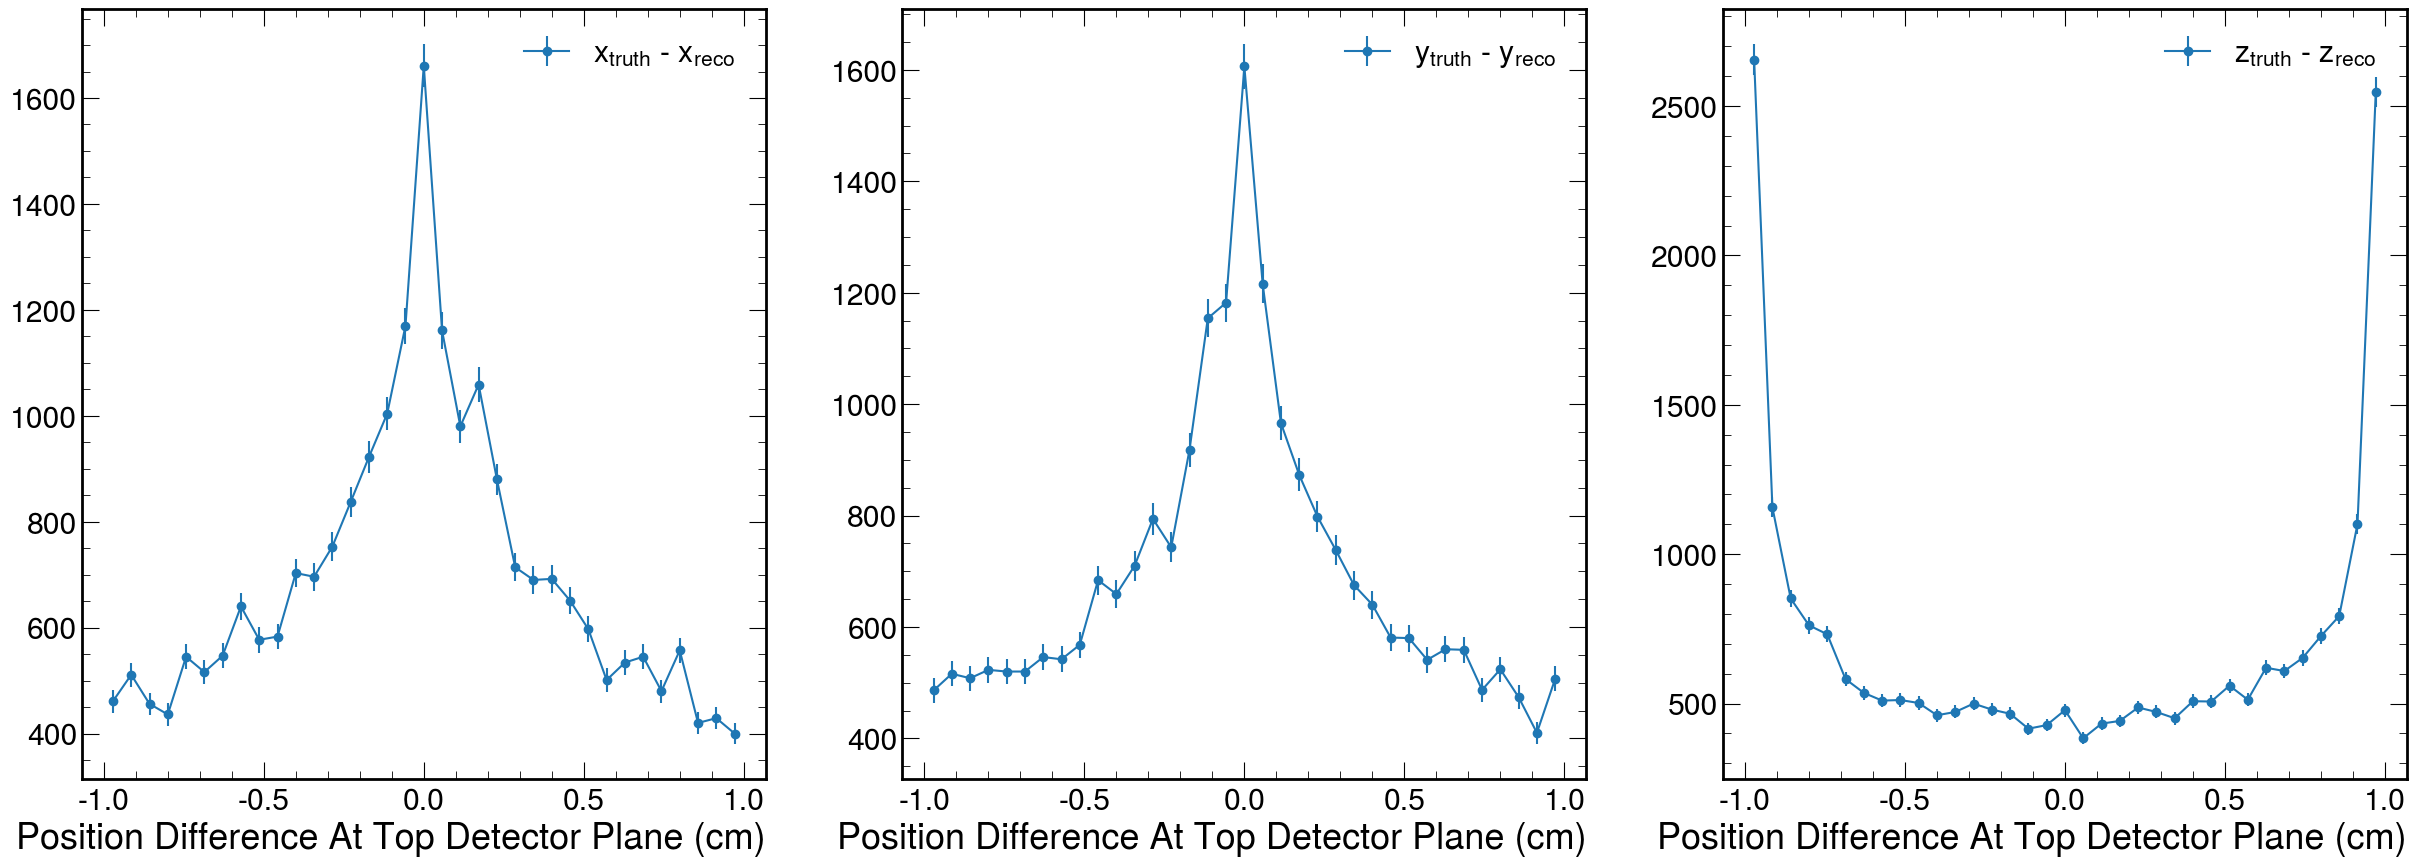

In [59]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
label = ['x','y','z']
for i in range(3):
    plt.sca(ax[i])
    
    y,x = np.histogram(diff_xyz[i],bins=35)
    bc=(x[1:]+x[:-1])/2
    plt.errorbar(bc,y,yerr=np.sqrt(y), fmt='-o',label=rf'{label[i]}$_{{truth}}$ - {label[i]}$_{{reco}}$')
    # coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(1000,0,0.2))
    # plt.errorbar(np.linspace(-10,10,200),gaus(np.linspace(-10,10,200),*coeff),fmt='--',label=rf'$\mu$ = {coeff[1]:.2f} cm, $\sigma$ = {abs(coeff[2]):.2f} cm')
    plt.legend()
    plt.xlabel('Position Difference At Top Detector Plane (cm)')